*Antonio Coín Castro*     


# Bayesian Functional Linear Regression - L2 model

In [1]:
# -- Libraries

from matplotlib import pyplot as plt
import arviz as az
import numpy as np
import pandas as pd
import pickle
import scipy
from multiprocessing import Pool
import utils

In [2]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)

# Multiprocessing
N_CORES = 4

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim BM$, a response variable given by a $L^2$ function, a value of $\alpha_0=5$ and a variance of $\sigma^2=1.5$:

$$
Y_i \sim \mathcal N\left(5 + \int_0^1 \beta(t)X_i(t)\, dt, \ 1.5\right),
$$

where $\beta(t)=5t\log(1+t)$.

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation.

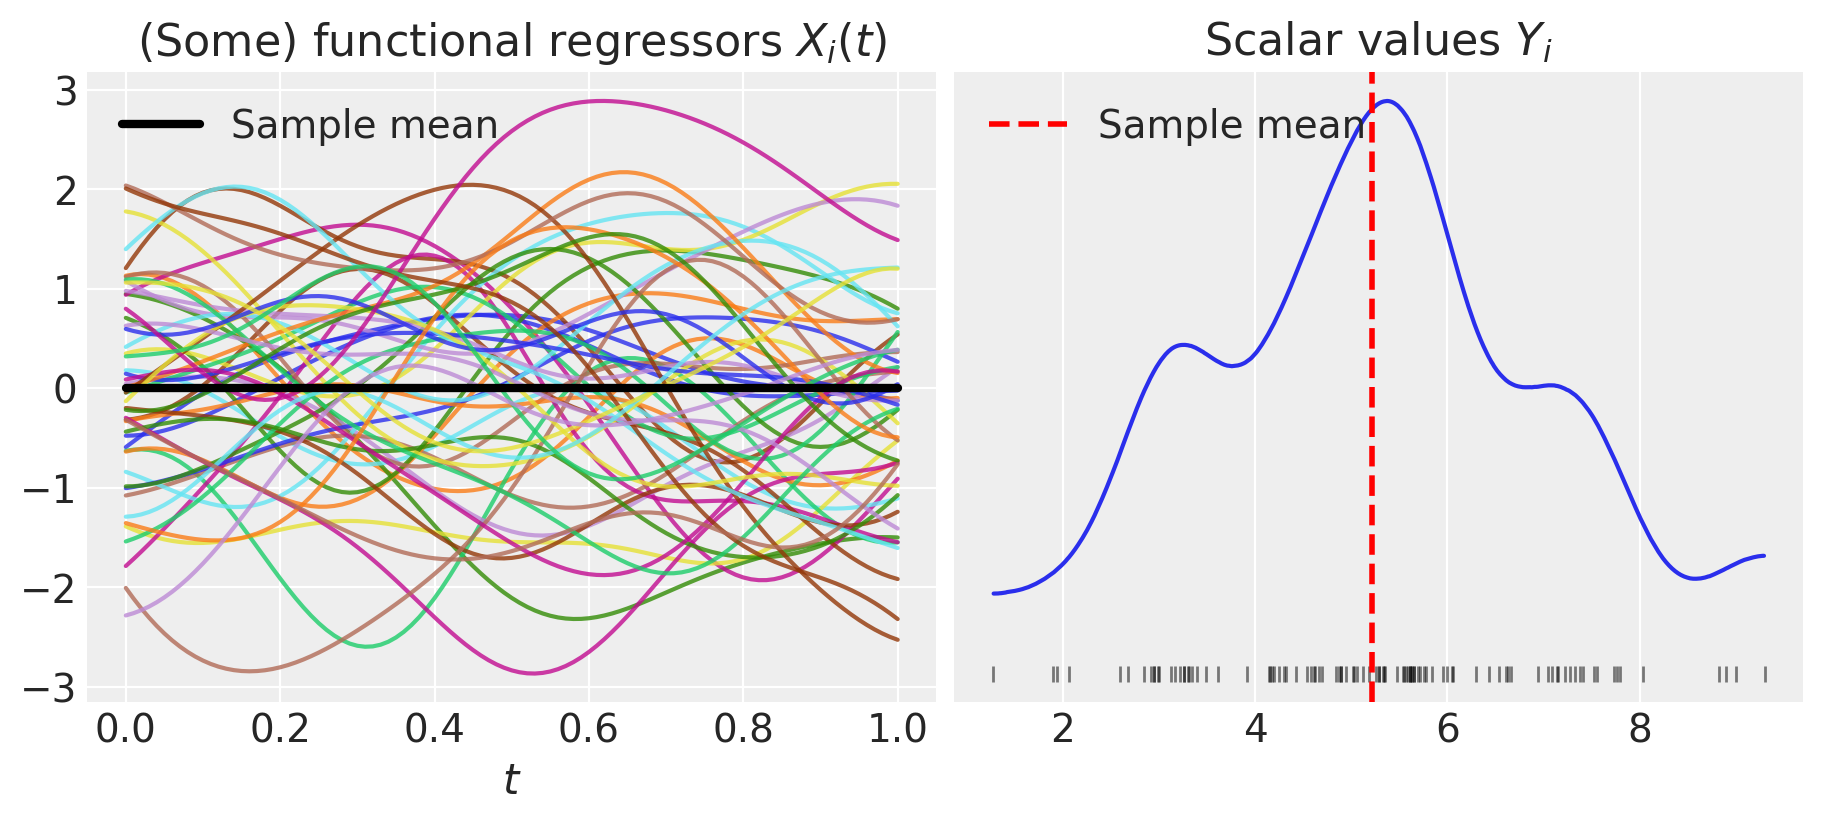

In [215]:
# -- Dataset generation

n_train, n_test = 100, 50
N = 101
grid = np.linspace(0., 1., N)

def beta_coef(t):
    return (5*np.exp(-20*(t-0.25)**2)
            - 2*np.exp(-20*(t-0.5)**2)
            + 2*np.exp(-20*(t-0.75)**2))


alpha0_true = 5.
sigma2_true = 1.5

X, Y = utils.generate_gp_l2_dataset(
    grid, utils.squared_exponential_kernel,
    n_train, beta_coef, alpha0_true, 
    sigma2_true, rng=rng
)

X_test, Y_test = utils.generate_gp_l2_dataset(
    grid, utils.squared_exponential_kernel,
    n_test, beta_coef, alpha0_true, 
    sigma2_true, rng=rng
)

# Standardize data
X_m = X.mean(axis=0)
X = X - X_m
X_test = X_test - X_m

utils.plot_dataset(X, Y)

## Sklearn model

In [257]:
# -- Fit regressor and show metrics

pipe = Pipeline([
    #("scaler", StandardScaler()),
    #("pca", PCA(n_components=0.95)),
    ("clf", Ridge(alpha=1.0, random_state=SEED))])

pipe.fit(X, Y)
Y_hat_sk = pipe.predict(X_test)
metrics_sk = utils.regression_metrics(Y_test, Y_hat_sk)

metrics_sk

{'mse': 1.3769974853604838, 'r2': 0.6626047994027237}

In [258]:
idxx

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

## Common model hyperparameters

In [226]:
# -- Model hyperparameters

p_hat = 3
g = 10
eta = 1.0
sd_beta_init = 5
sd_alpha0_init = 10*np.abs(Y.mean())  # Grollemund et al (?)
sd_log_sigma_init = 1

In [227]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
theta_names_aux = ["α0 and logσ", "logσ"]

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]

# Individual labels
theta_labels = []
for i in range(p_hat):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_hat):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={"projection": dict(
        zip(np.arange(p_hat), np.arange(1, p_hat + 1)))}
)

# Dimension of parameter vector
theta_ndim = len(theta_labels)

# Dimension of grouped parameter vector
theta_ndim_grouped = len(theta_names)

## Maximum Likelihood Estimator

In [6]:
# -- Negative log-likelihood definition

def neg_ll(theta, X, Y):
    assert len(theta) % 2 == 0

    n, N = X.shape
    grid = np.linspace(0., 1., N)
    p = (len(theta) - 2)//2

    beta = theta[:p]
    tau = theta[p:2*p]
    alpha0 = theta[-2]
    log_sigma = theta[-1]
    sigma = np.exp(log_sigma)

    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]

    return -(-n*log_sigma
             - np.linalg.norm(Y - alpha0 - X_tau@beta)**2/(2*sigma**2))

In [228]:
# -- MLE estimation

# We artificially restrict the variance to a sensible value
bounds = [(None, None)]*p_hat + [(0.0, 1.0)] * \
    p_hat + [(None, None)] + [(None, np.log(2*Y.std()))]

theta_init = utils.initial_guess_random(
    p_hat, sd_beta_init,
    sd_alpha0_init,
    sd_log_sigma_init,
    rng=rng),

mle = scipy.optimize.minimize(
    neg_ll,
    x0=theta_init,
    args=(X, Y),
    bounds=bounds,
)
mle_theta = mle.x
mle_orig = np.copy(mle_theta)
mle_orig[-1] = np.exp(mle_theta[-1])**2  # Transform back to sigma^2

pd.DataFrame(zip(theta_labels, mle_orig),
             columns=["", "MLE"]).style.hide_index()

## The Ensemble Sampler and the *emcee* library

In [9]:
import emcee

### Model

We only need to provide the sampler with the logarithm of the posterior distribution. For clarity we split up its computation in log-prior and log-likelihood, although for a more efficient implementation it should all be in one function. 

In [10]:
# -- Log-posterior model

def log_prior(theta):
    """Global parameters (for efficient parallelization): X, b0, g, eta"""
    assert len(theta) % 2 == 0

    n, N = X.shape
    p = (len(theta) - 2)//2
    grid = np.linspace(0., 1., N)

    beta = theta[:p]
    tau = theta[p:2*p]
    alpha0 = theta[-2]
    log_sigma = theta[-1]

    # Transform variables
    b = beta - b0
    sigma = np.exp(log_sigma)

    # Impose constraints on parameters
    if (tau < 0.0).any() or (tau > 1.0).any():
        return -np.inf

    # Compute and regularize G_tau
    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    G_tau = X_tau.T@X_tau
    G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
    G_tau_reg = G_tau + eta * \
        np.max(np.linalg.eigvalsh(G_tau))*np.identity(p)

    # Compute log-prior
    log_prior = (0.5*utils.logdet(G_tau_reg)
                 - (p + 2)*log_sigma
                 - b.T@G_tau_reg@b/(2*g*sigma**2))

    return log_prior


def log_likelihood(theta, Y):
    """Global parameters (for efficient parallelization): X"""
    return -neg_ll(theta, X, Y)


def log_posterior(theta, Y):
    """Global parameters (for efficient parallelization): X, rng, return_pps"""
    lp = log_prior(theta)

    if not np.isfinite(lp):
        if return_pps:
            return -np.inf, np.full_like(Y, -np.inf)
        else:
            return -np.inf

    ll = log_likelihood(theta, Y)
    lpos = lp + ll

    if return_pps:
        theta_orig = np.copy(theta)
        theta_orig[-1] = np.exp(theta_orig[-1])**2
        pps = utils.generate_response(X, theta_orig, rng=rng)
        return lpos, pps
    else:
        return lpos

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [229]:
# -- Sampler parameters

n_walkers = 150
n_iter_initial = 500
n_iter = 2000
return_pps = True

# Start every walker in a (random) neighbourhood around the MLE
p0 = utils.intial_guess_around_value(
    mle_theta, n_walkers=n_walkers, rng=rng)

b0 = mle_theta[:p_hat]  # <-- Change if needed

In [230]:
# -- Run sampler

with Pool(N_CORES) as pool:
    print(
        f"-- Running affine-invariant ensemble sampler with {N_CORES} cores --")

    sampler = emcee.EnsembleSampler(
        n_walkers, theta_ndim, log_posterior, pool=pool, args=(Y,))

    print("Tuning phase...")
    state = sampler.run_mcmc(
        p0, n_iter_initial, progress='notebook',
        store=False)
    sampler.reset()

    print("MCMC sampling...")
    sampler.run_mcmc(state, n_iter, progress='notebook')
    
print(
    f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")

-- Running affine-invariant ensemble sampler with 4 cores --
Tuning phase...


  0%|          | 0/500 [00:00<?, ?it/s]

MCMC sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean acceptance fraction: 35.669%


### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value.

In [260]:
# -- Sampler statistics and trace (with burn-in and thinning)

# Analyze autocorrelation and set burn-in and thinning values
autocorr = sampler.get_autocorr_time(quiet=True)
max_autocorr = np.max(autocorr)
burn = int(3*max_autocorr)
thin = 1

# Get InferenceData object
idata_emcee = utils.emcee_to_idata(
    sampler, p_hat, theta_names, theta_names_aux[1:],
    burn, thin, return_pps)

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [ 95.905  99.956  98.733 109.961  89.582 104.965  80.78   91.001]


In [27]:
utils.summary(idata_emcee, var_names=theta_names,
              kind="stats", labeller=theta_labeller)

mean     sd  hdi_3%  hdi_97%   mode
β[1]        0.127  0.621  -1.192    1.442  0.163
β[2]        0.855  0.717  -0.558    2.136  0.792
β[3]       -0.310  0.583  -1.535    0.716 -0.067
τ[1]        0.514  0.317   0.020    0.955  0.761
τ[2]        0.132  0.176   0.000    0.497  0.032
τ[3]        0.391  0.266   0.002    0.855  0.103
$\alpha_0$  5.073  0.116   4.852    5.286  5.082
$\sigma^2$  1.261  0.188   0.891    1.584  1.164

Combined density and trace plot:


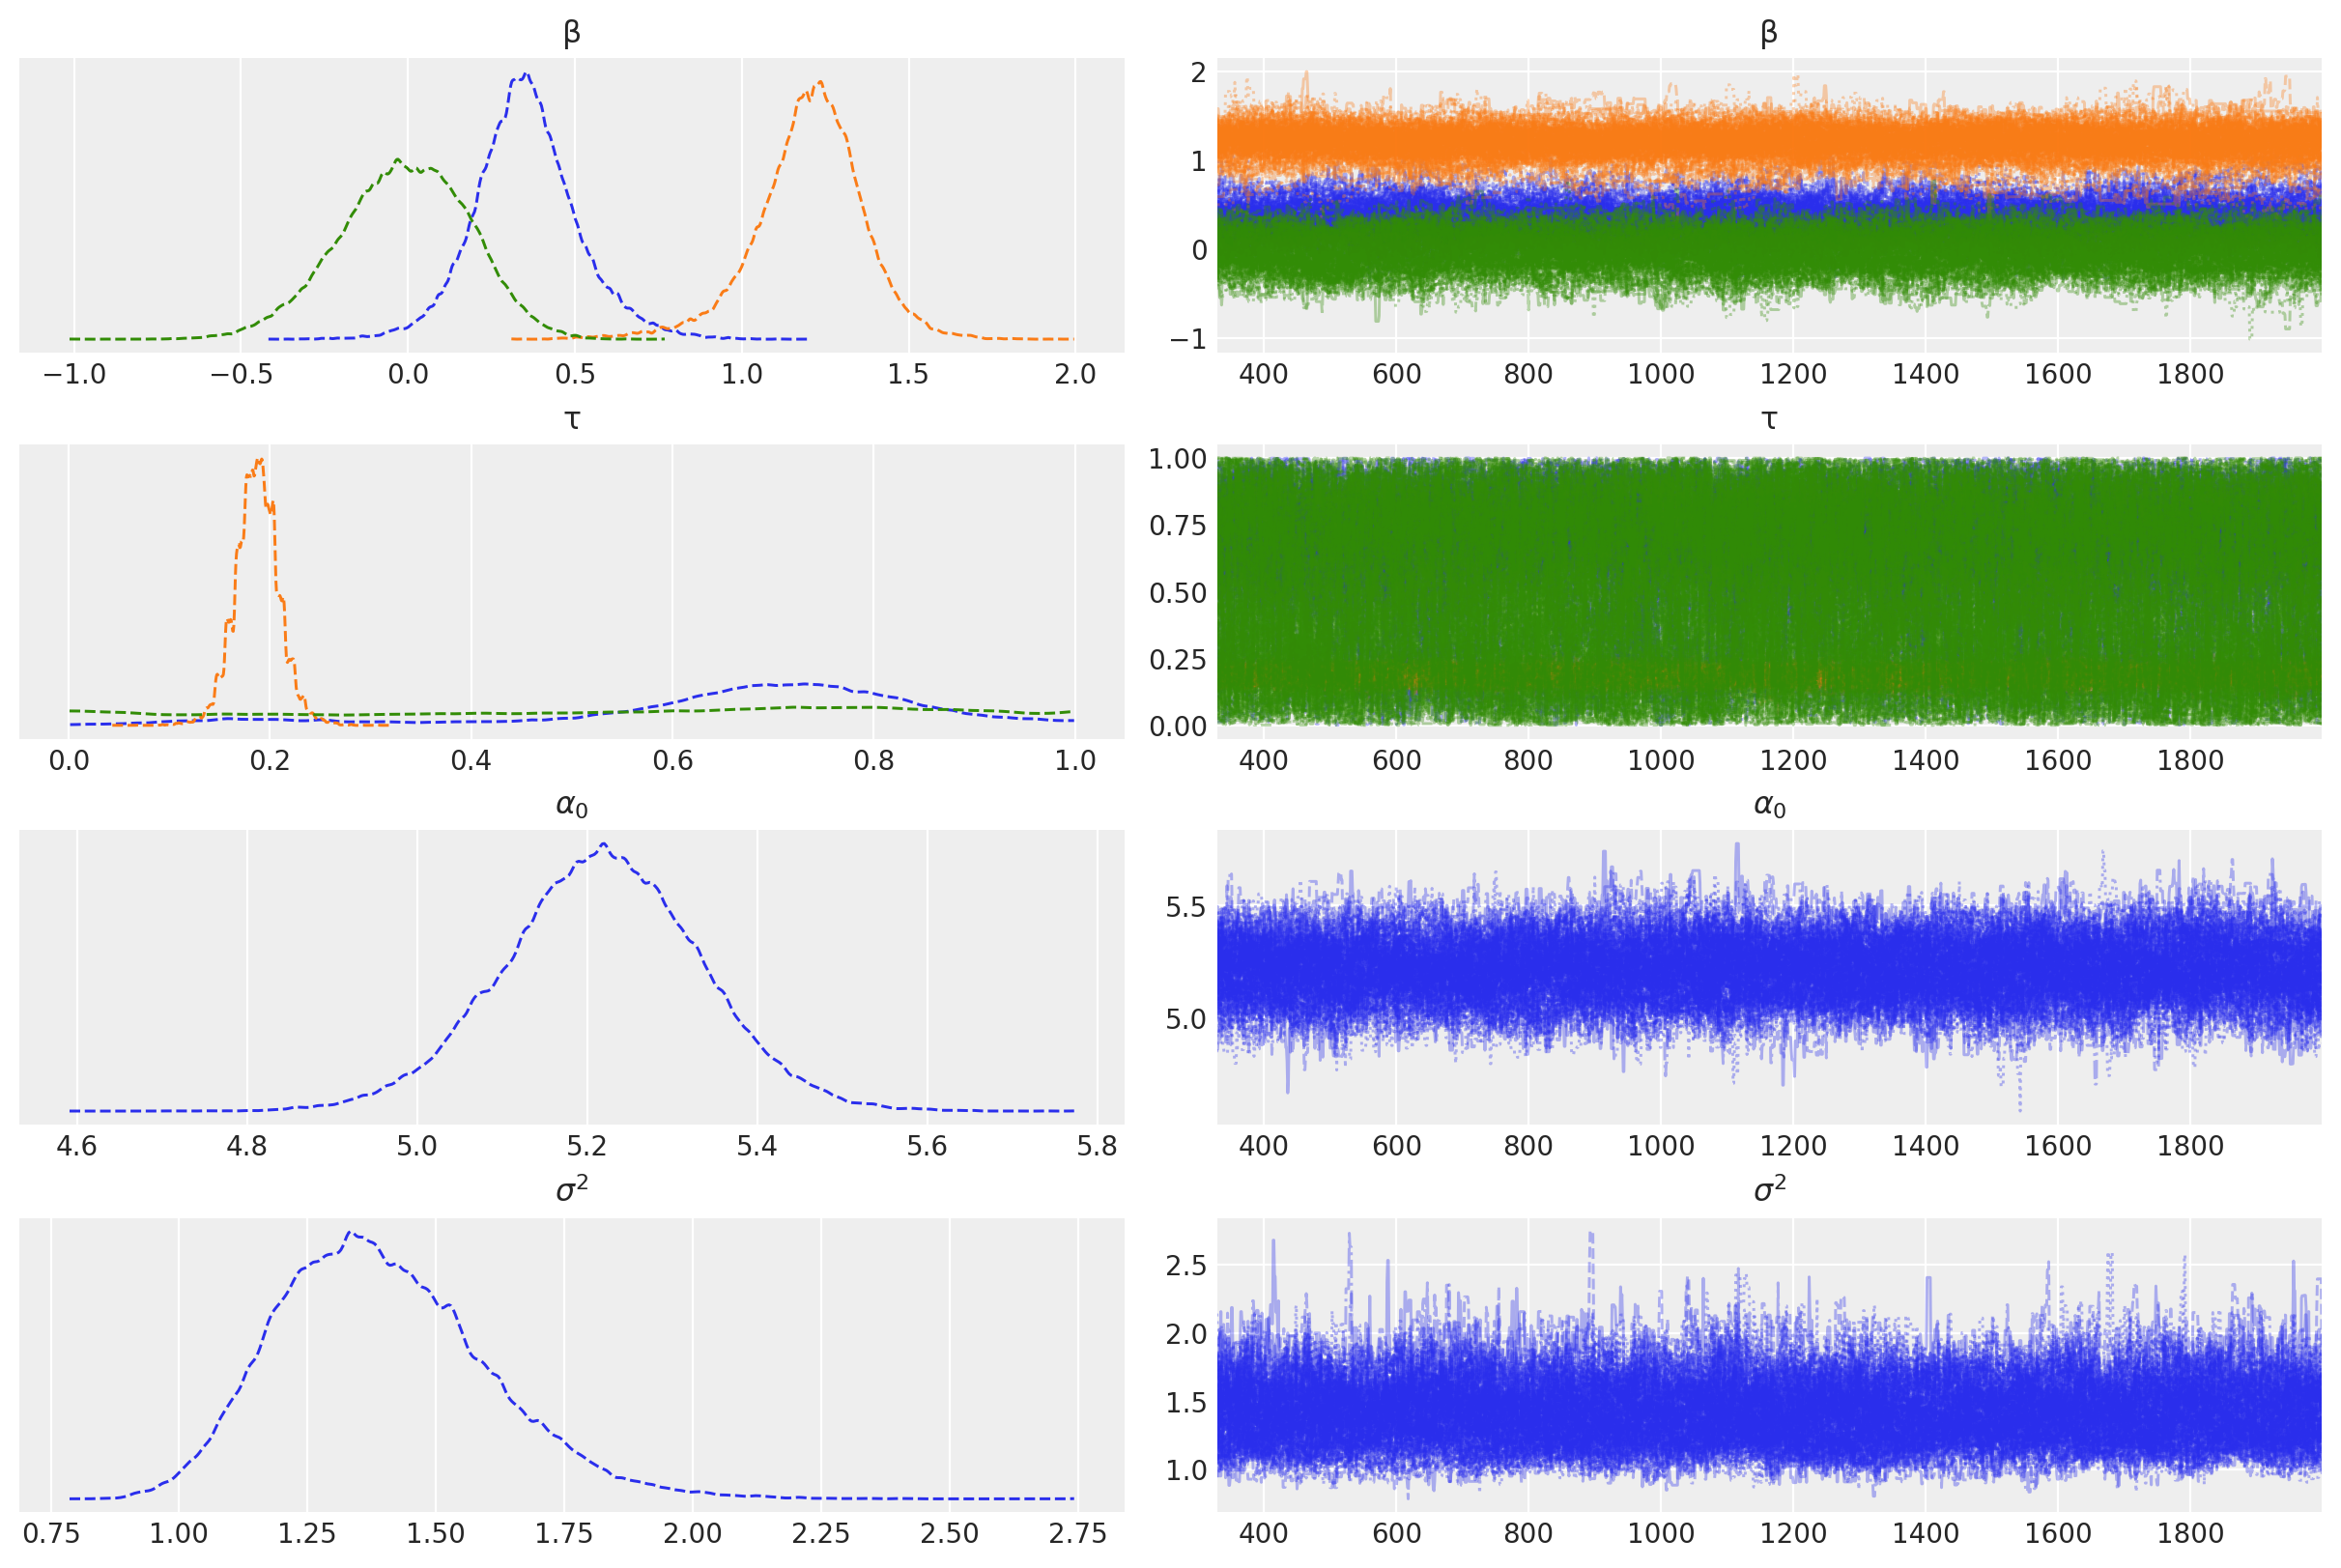

In [232]:
az.plot_trace(idata_emcee, labeller=theta_labeller,
              combined=True, var_names=theta_names)
print("Combined density and trace plot:")

Marginal posterior distributions:


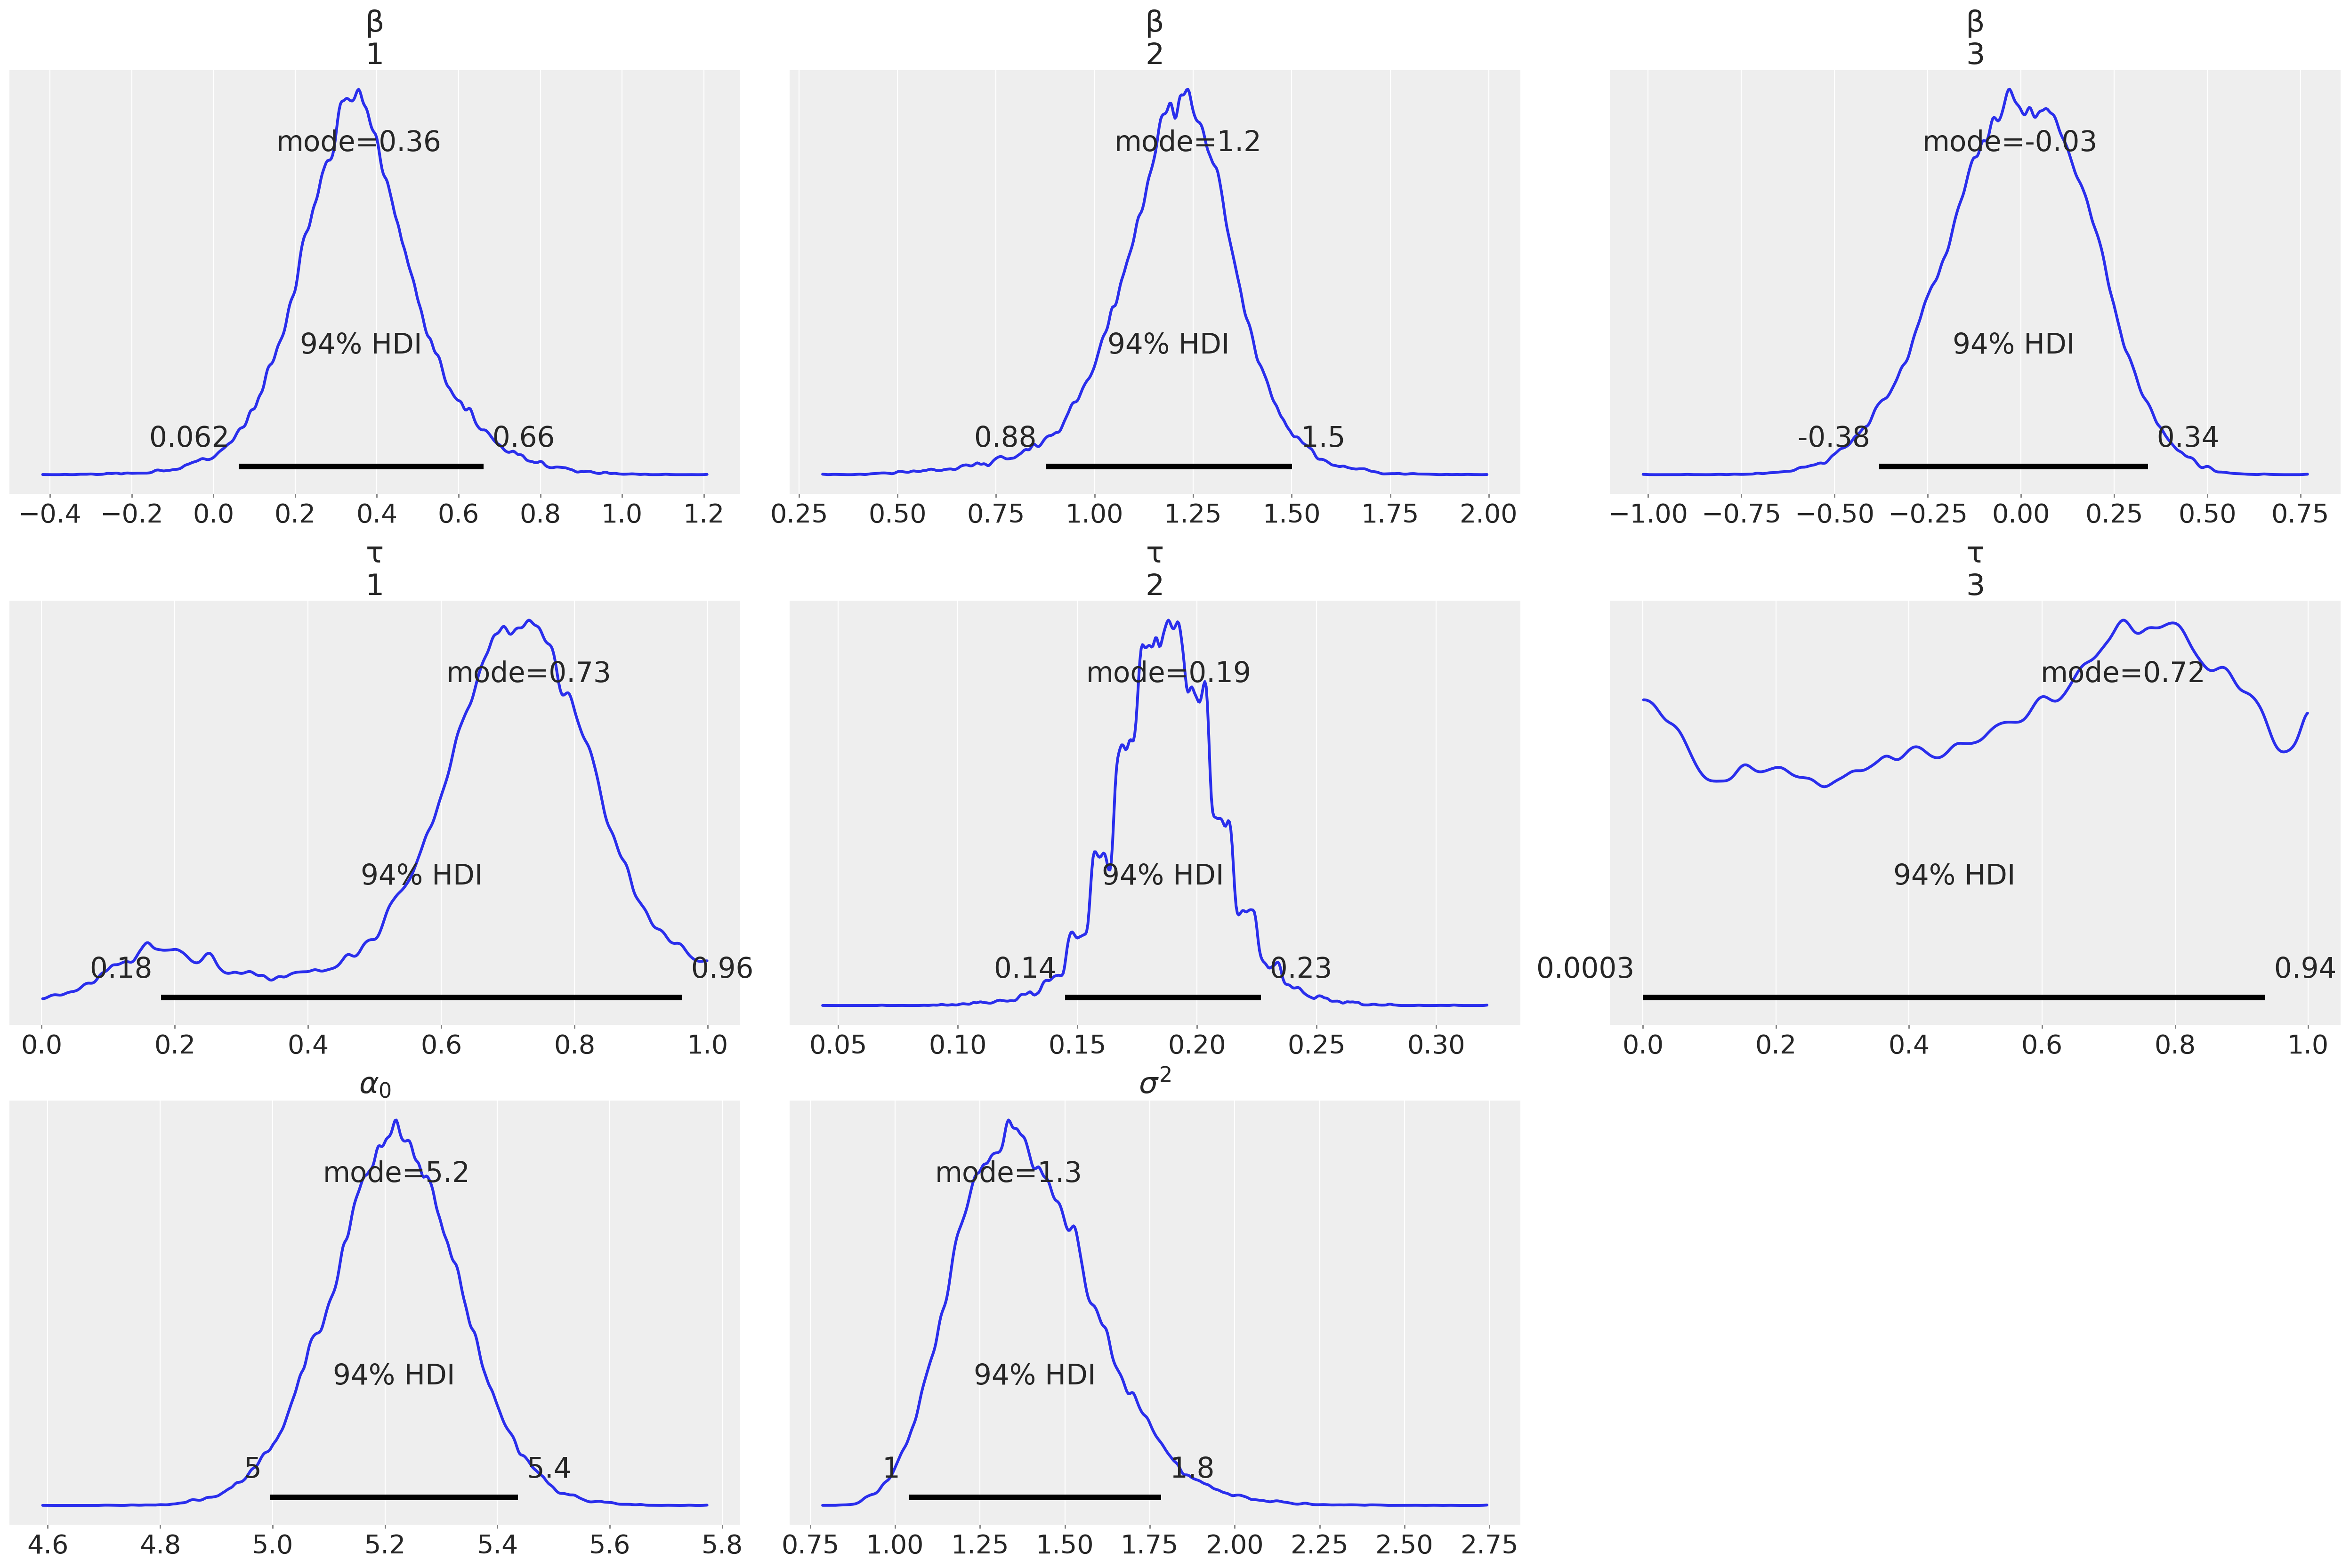

In [233]:
az.plot_posterior(idata_emcee, labeller=theta_labeller, point_estimate='mode',
                  grid=(NROWS(theta_ndim), NCOLS), textsize=20,
                  var_names=theta_names)
print("Marginal posterior distributions:")

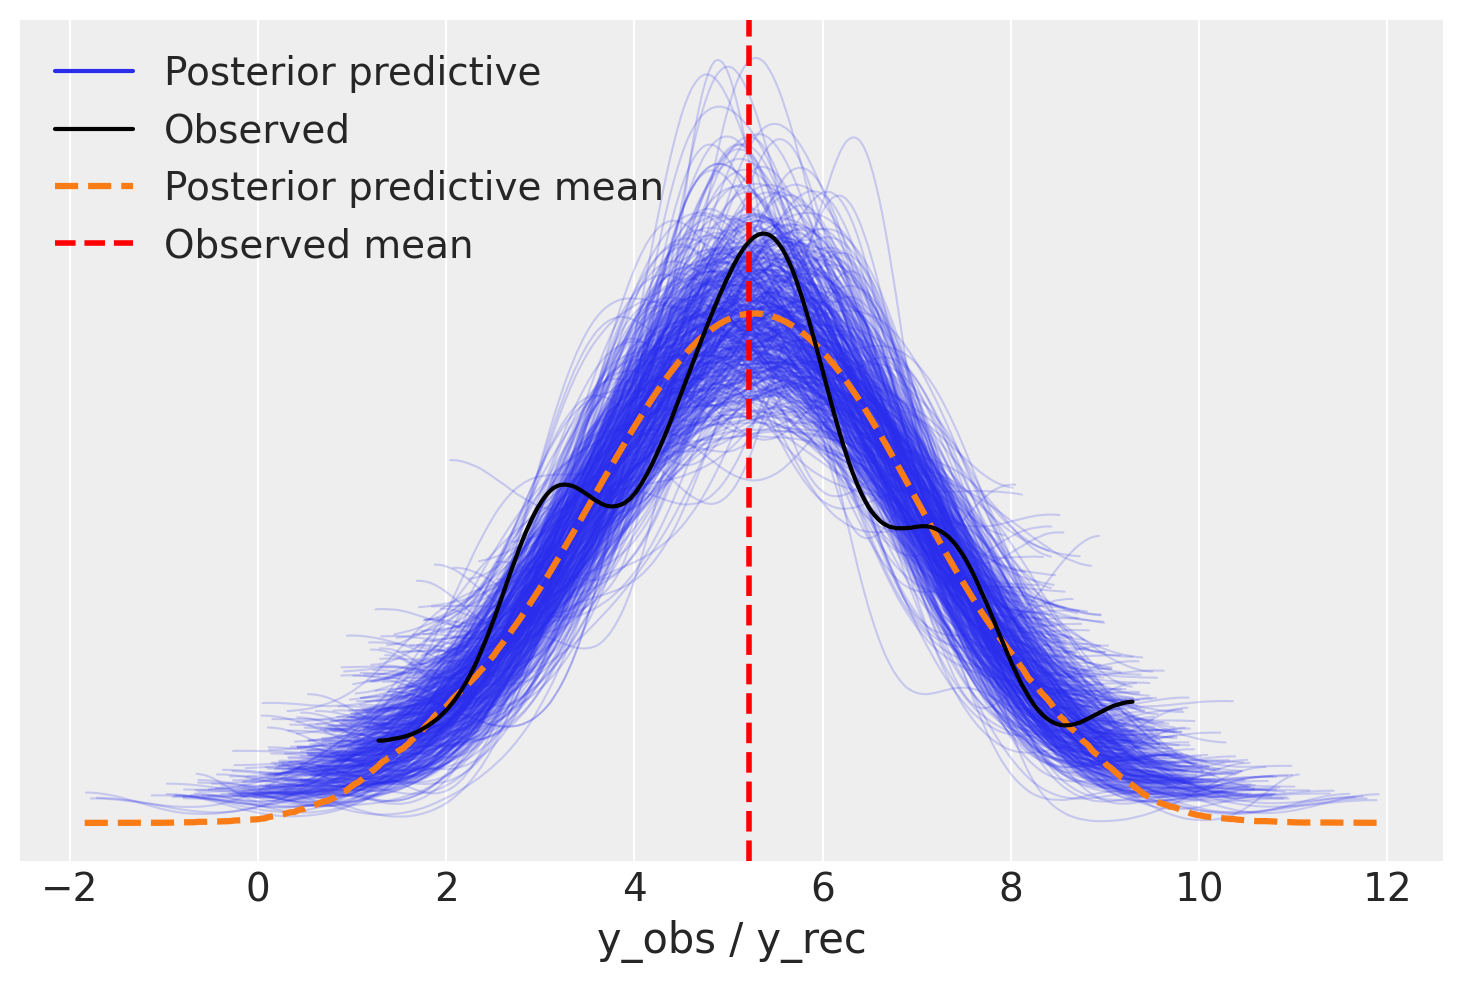

In [234]:
# -- Generate and plot posterior predictive samples from X

if "posterior_predictive" not in idata_emcee:
    ppc = utils.generate_ppc(idata_emcee, X, theta_names, rng=rng)
    idata_ppc = utils.ppc_to_idata(ppc, idata_emcee, "y_rec")
else:
    idata_ppc = idata_emcee

utils.plot_ppc(idata_ppc, n_samples=500, data_pairs={'y_obs': 'y_rec'})

Combined autocorrelation times:


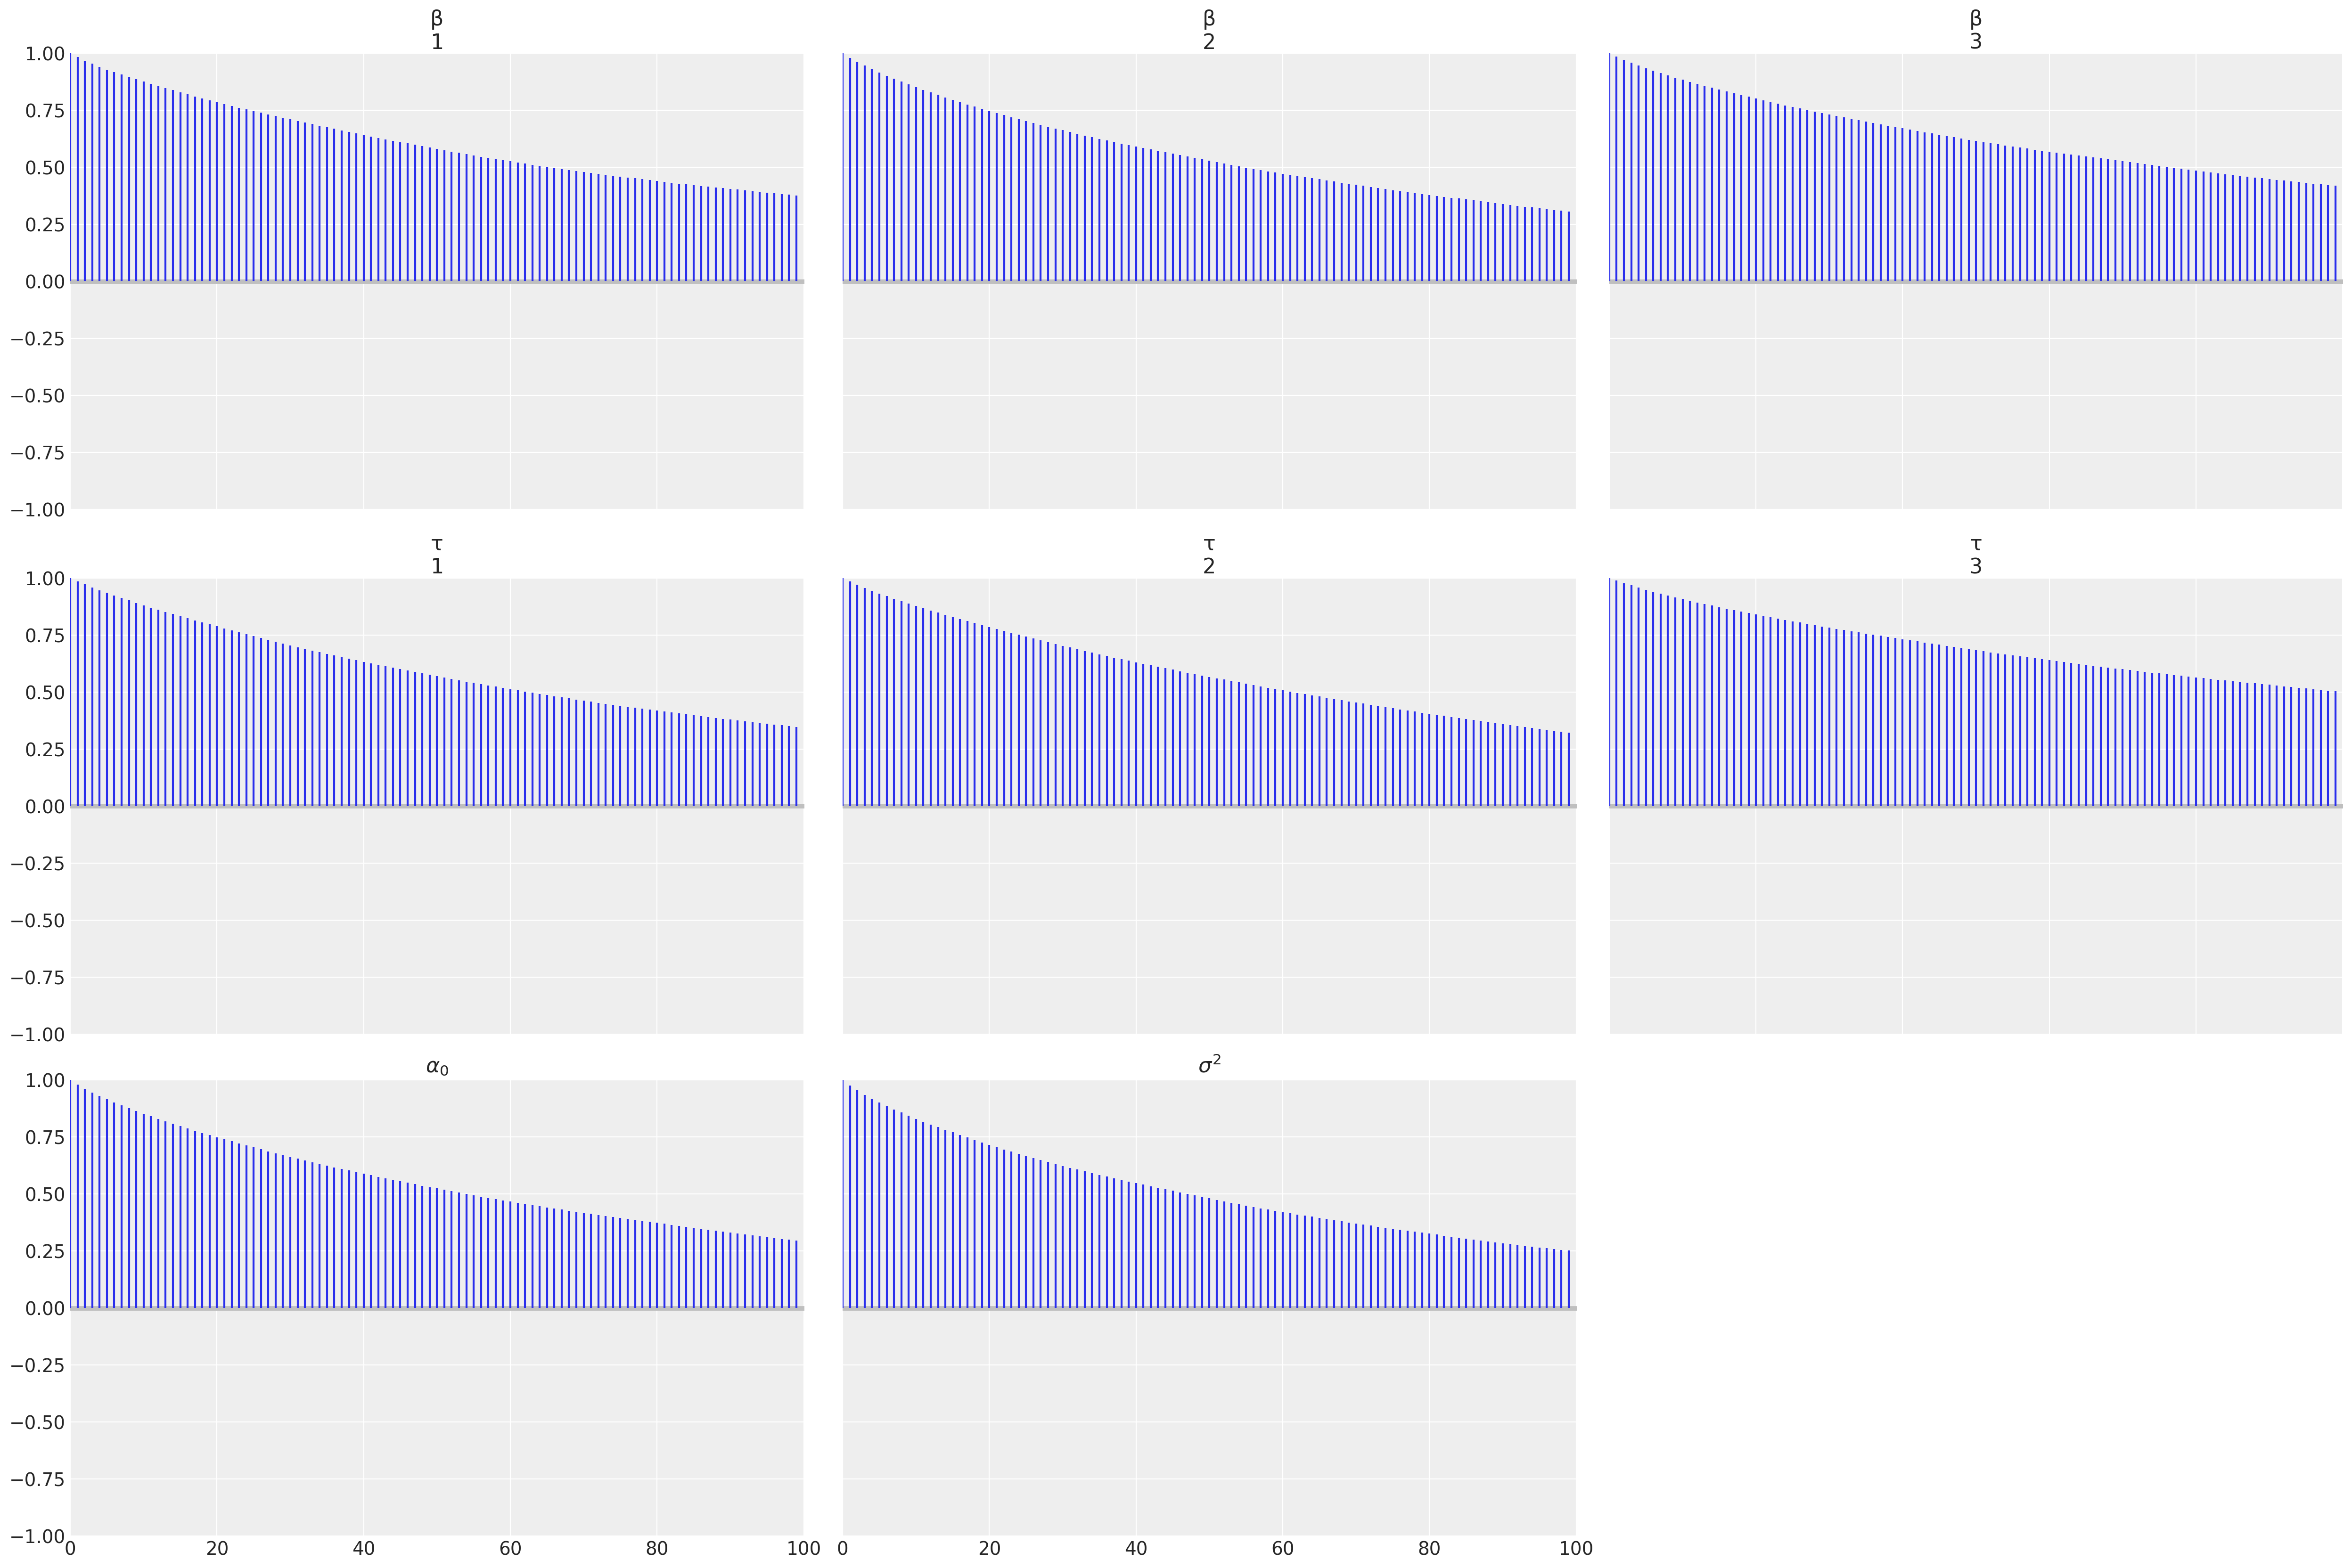

In [17]:
az.plot_autocorr(idata_emcee, combined=True, var_names=theta_names,
                 grid=(NROWS(theta_ndim), NCOLS), labeller=theta_labeller)
print("Combined autocorrelation times:")

### Out-of-sample predictions

Posterior predictive samples:   0%|          | 0/200 [00:00<?, ?it/s]

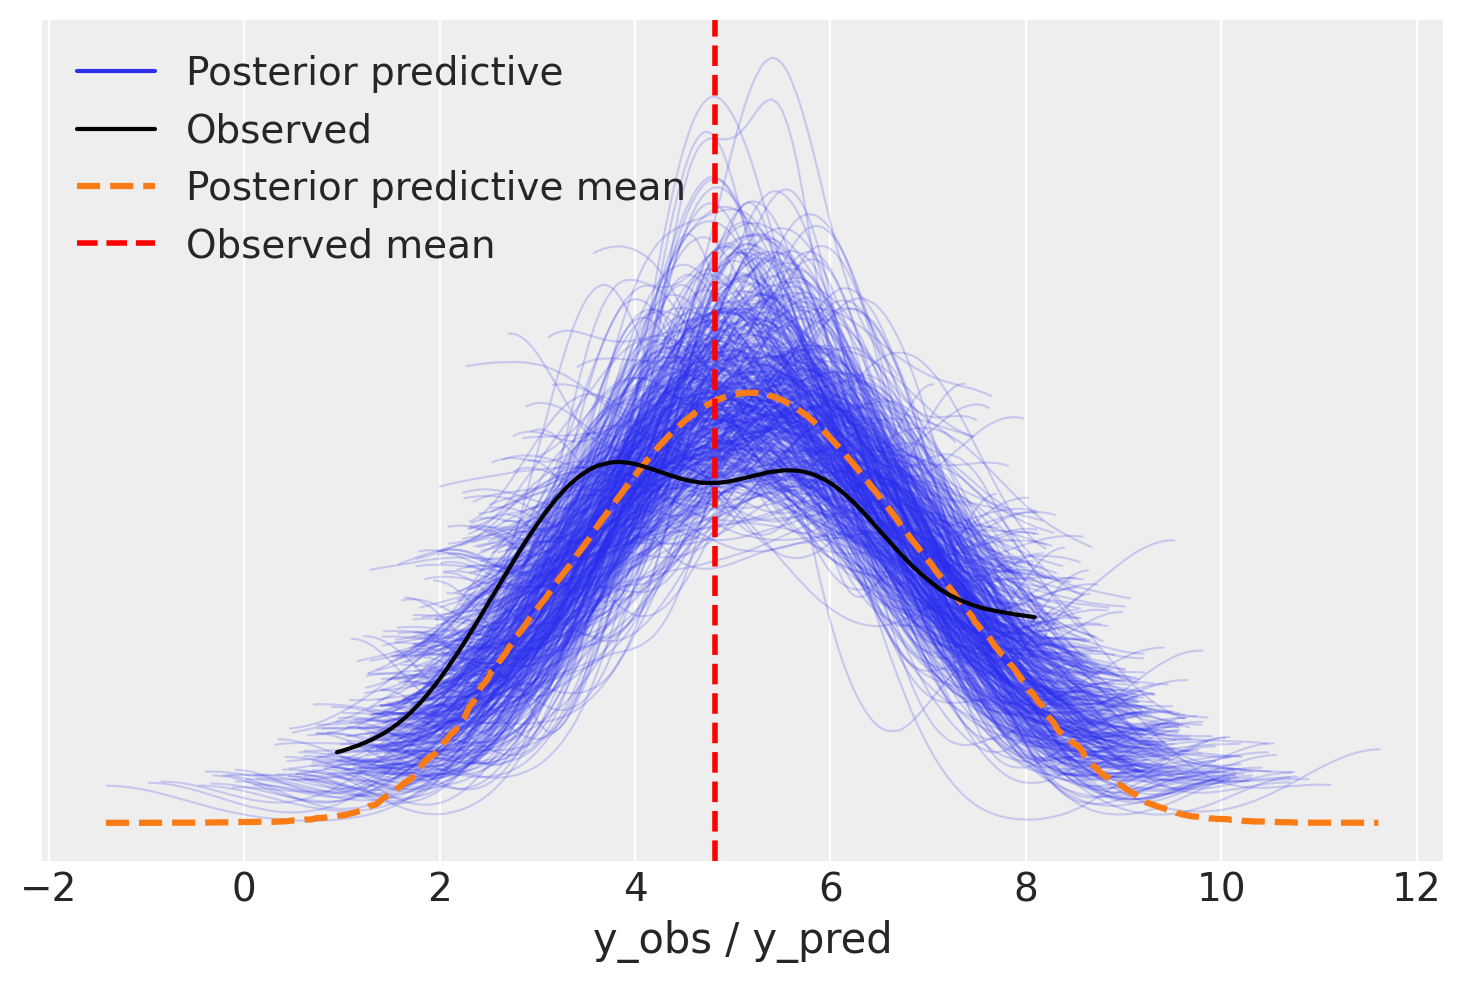

In [136]:
# -- Generate and plot posterior predictive samples from X_test

ppc = utils.generate_ppc(idata_emcee, X_test, theta_names, rng=rng)
idata_ppc = utils.ppc_to_idata(ppc, idata_emcee, "y_pred", y_obs=Y_test)

utils.plot_ppc(idata_ppc, n_samples=500, data_pairs={'y_obs': 'y_pred'})

In [261]:
# -- Compute metrics using several point estimates

point_estimates = ["mode", "mean", "median"]

metrics_emcee = pd.DataFrame(
    columns=["Point estimate", "MSE", "RMSE", r"$R^2$"])

for pe in point_estimates:
    Y_hat = utils.point_predict(
        X_test, idata_emcee,
        theta_names, pe)
    metrics = utils.regression_metrics(Y_test, Y_hat)
    metrics_emcee.loc[pe] = [
        pe, 
        metrics["mse"], 
        np.sqrt(metrics["mse"]), 
        metrics["r2"]
    ]
    

metrics_emcee.loc["sklearn"] = [
    "sklearn",
    metrics_sk["mse"],
    np.sqrt(metrics_sk["mse"]),
    metrics_sk["r2"]
]

metrics_emcee.style.hide_index()

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [40]:
with open("emcee-p-fixed.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [37]:
with open("emcee-p-fixed.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

In [20]:
import pymc3 as pm
import theano
import theano.tensor as tt

### Model

In [23]:
# -- Probabilistic model

def make_model(p, g, eta, X, Y, names, names_aux, mle_theta=None):
    n, N = X.shape
    grid = np.linspace(0., 1., N)

    if mle_theta is not None:
        b0 = mle_theta[:p]
    else:
        b0 = g*rng.standard_normal(size=p)  # <-- Change if needed

    with pm.Model() as model:
        X_pm = pm.Data('X', X)

        alpha0_and_log_sigma = pm.DensityDist(
            names_aux[0], lambda x: 0, shape=(2,))

        alpha0 = pm.Deterministic(names[-2], alpha0_and_log_sigma[0])

        log_sigma = alpha0_and_log_sigma[1]
        sigma = pm.math.exp(log_sigma)
        sigma2 = pm.Deterministic(names[-1], sigma**2)

        tau = pm.Uniform(names[1], 0.0, 1.0, shape=(p,))

        idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
        X_tau = X_pm[:, idx]
        G_tau = pm.math.matrix_dot(X_tau.T, X_tau)
        G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
        G_tau_reg = G_tau + eta * \
            tt.max(tt.nlinalg.eigh(G_tau)[0])*np.identity(p)

        def beta_lprior(x):
            b = x - b0

            return (0.5*pm.math.logdet(G_tau_reg)
                    - p*log_sigma
                    - pm.math.matrix_dot(b.T, G_tau_reg, b)/(2.*g*sigma2))

        beta = pm.DensityDist(names[0], beta_lprior, shape=(p,))

        expected_obs = alpha0 + pm.math.matrix_dot(X_tau, beta)

        y_obs = pm.Normal('y_obs', mu=expected_obs, sigma=sigma, observed=Y)

    return model

### Experiments

In [24]:
# -- NUTS with MLE as starting point

model_mle = make_model(p_hat, g, eta, X, Y, theta_names,
                       theta_names_aux[:1], mle_theta)

with model_mle:
    print("Starting from MLE...")
    ttr = model_mle.named_vars[theta_names[1]].transformation
    start = {theta_names[0]: mle_theta[:p_hat],
             theta_names[1] + "_interval__":
                 ttr.forward(mle_theta[p_hat:2*p_hat]).eval(),
             theta_names_aux[0]: mle_theta[-2:]}

    idata_mle = pm.sample(1000, cores=2, tune=1000, start=start,
                          target_accept=0.8, return_inferencedata=True)

Starting from MLE...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, τ, α0 and logσ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [25]:
utils.summary(idata_mle, var_names=theta_names,
              kind="stats", labeller=theta_labeller)

mean     sd  hdi_3%  hdi_97%    mode
β[0]        9.983  0.194   9.619   10.358  10.029
β[1]       -4.470  0.403  -5.398   -3.819  -4.388
β[2]        0.279  0.465  -0.495    1.389   0.335
τ[0]        0.800  0.003   0.796    0.805   0.803
τ[1]        0.100  0.003   0.096    0.105   0.098
τ[2]        0.311  0.252   0.000    0.842   0.001
$\alpha_0$  5.573  0.118   5.368    5.814   5.583
$\sigma^2$  1.394  0.198   1.033    1.743   1.287

In [26]:
# -- NUTS with MAP as starting point

model_map = make_model(p_hat, g, eta, X, Y, theta_names,
                       theta_names_aux[:1], mle_theta)

with model_map:
    print("Computing MAP estimate...")
    start = pm.find_MAP()

    print("Starting from MAP estimate...")
    idata_map = pm.sample(1000, cores=2, tune=1000, start=start,
                          target_accept=0.8, return_inferencedata=True)

Computing MAP estimate...



Starting from MAP estimate...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, τ, α0 and logσ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [27]:
utils.summary(idata_map, var_names=theta_names,
              kind="stats", labeller=theta_labeller)

mean     sd  hdi_3%  hdi_97%    mode
β[0]        9.990  0.223   9.600   10.364  10.061
β[1]       -4.521  0.422  -5.275   -3.724  -4.402
β[2]        0.312  0.530  -0.637    1.289   0.350
τ[0]        0.800  0.003   0.795    0.804   0.795
τ[1]        0.100  0.003   0.096    0.105   0.102
τ[2]        0.308  0.257   0.001    0.827   0.001
$\alpha_0$  5.585  0.123   5.361    5.814   5.594
$\sigma^2$  1.390  0.199   1.020    1.727   1.344

In [28]:
# -- NUTS with auto initialization

model_auto = make_model(p_hat, g, eta, X, Y, theta_names,
                        theta_names_aux[:1], mle_theta)

with model_auto:
    idata_auto = pm.sample(1000, cores=2, tune=1000, target_accept=0.8,
                           return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, τ, α0 and logσ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [29]:
utils.summary(idata_auto, var_names=theta_names,
              kind="stats", labeller=theta_labeller)

mean     sd  hdi_3%  hdi_97%   mode
β[0]        10.001  0.191   9.621   10.327  9.991
β[1]        -4.537  0.467  -5.431   -3.728 -4.462
β[2]         0.295  0.486  -0.732    1.196  0.202
τ[0]         0.800  0.003   0.796    0.805  0.797
τ[1]         0.100  0.003   0.095    0.105  0.104
τ[2]         0.284  0.243   0.000    0.807  0.001
$\alpha_0$   5.591  0.119   5.362    5.803  5.593
$\sigma^2$   1.377  0.203   1.001    1.761  1.327

### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

Graphical model:


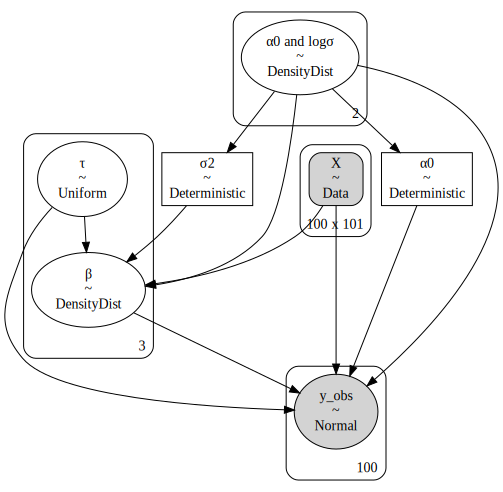

In [30]:
# -- Select and print best model (with burn-in and thinning)

burn = 0
thin = 1

model = model_auto
idata_pymc = idata_auto
idata_pymc = idata_pymc.sel(draw=slice(burn, None, thin))

print("Graphical model:")
pm.model_graph.model_to_graphviz(model)

Density and trace plot:


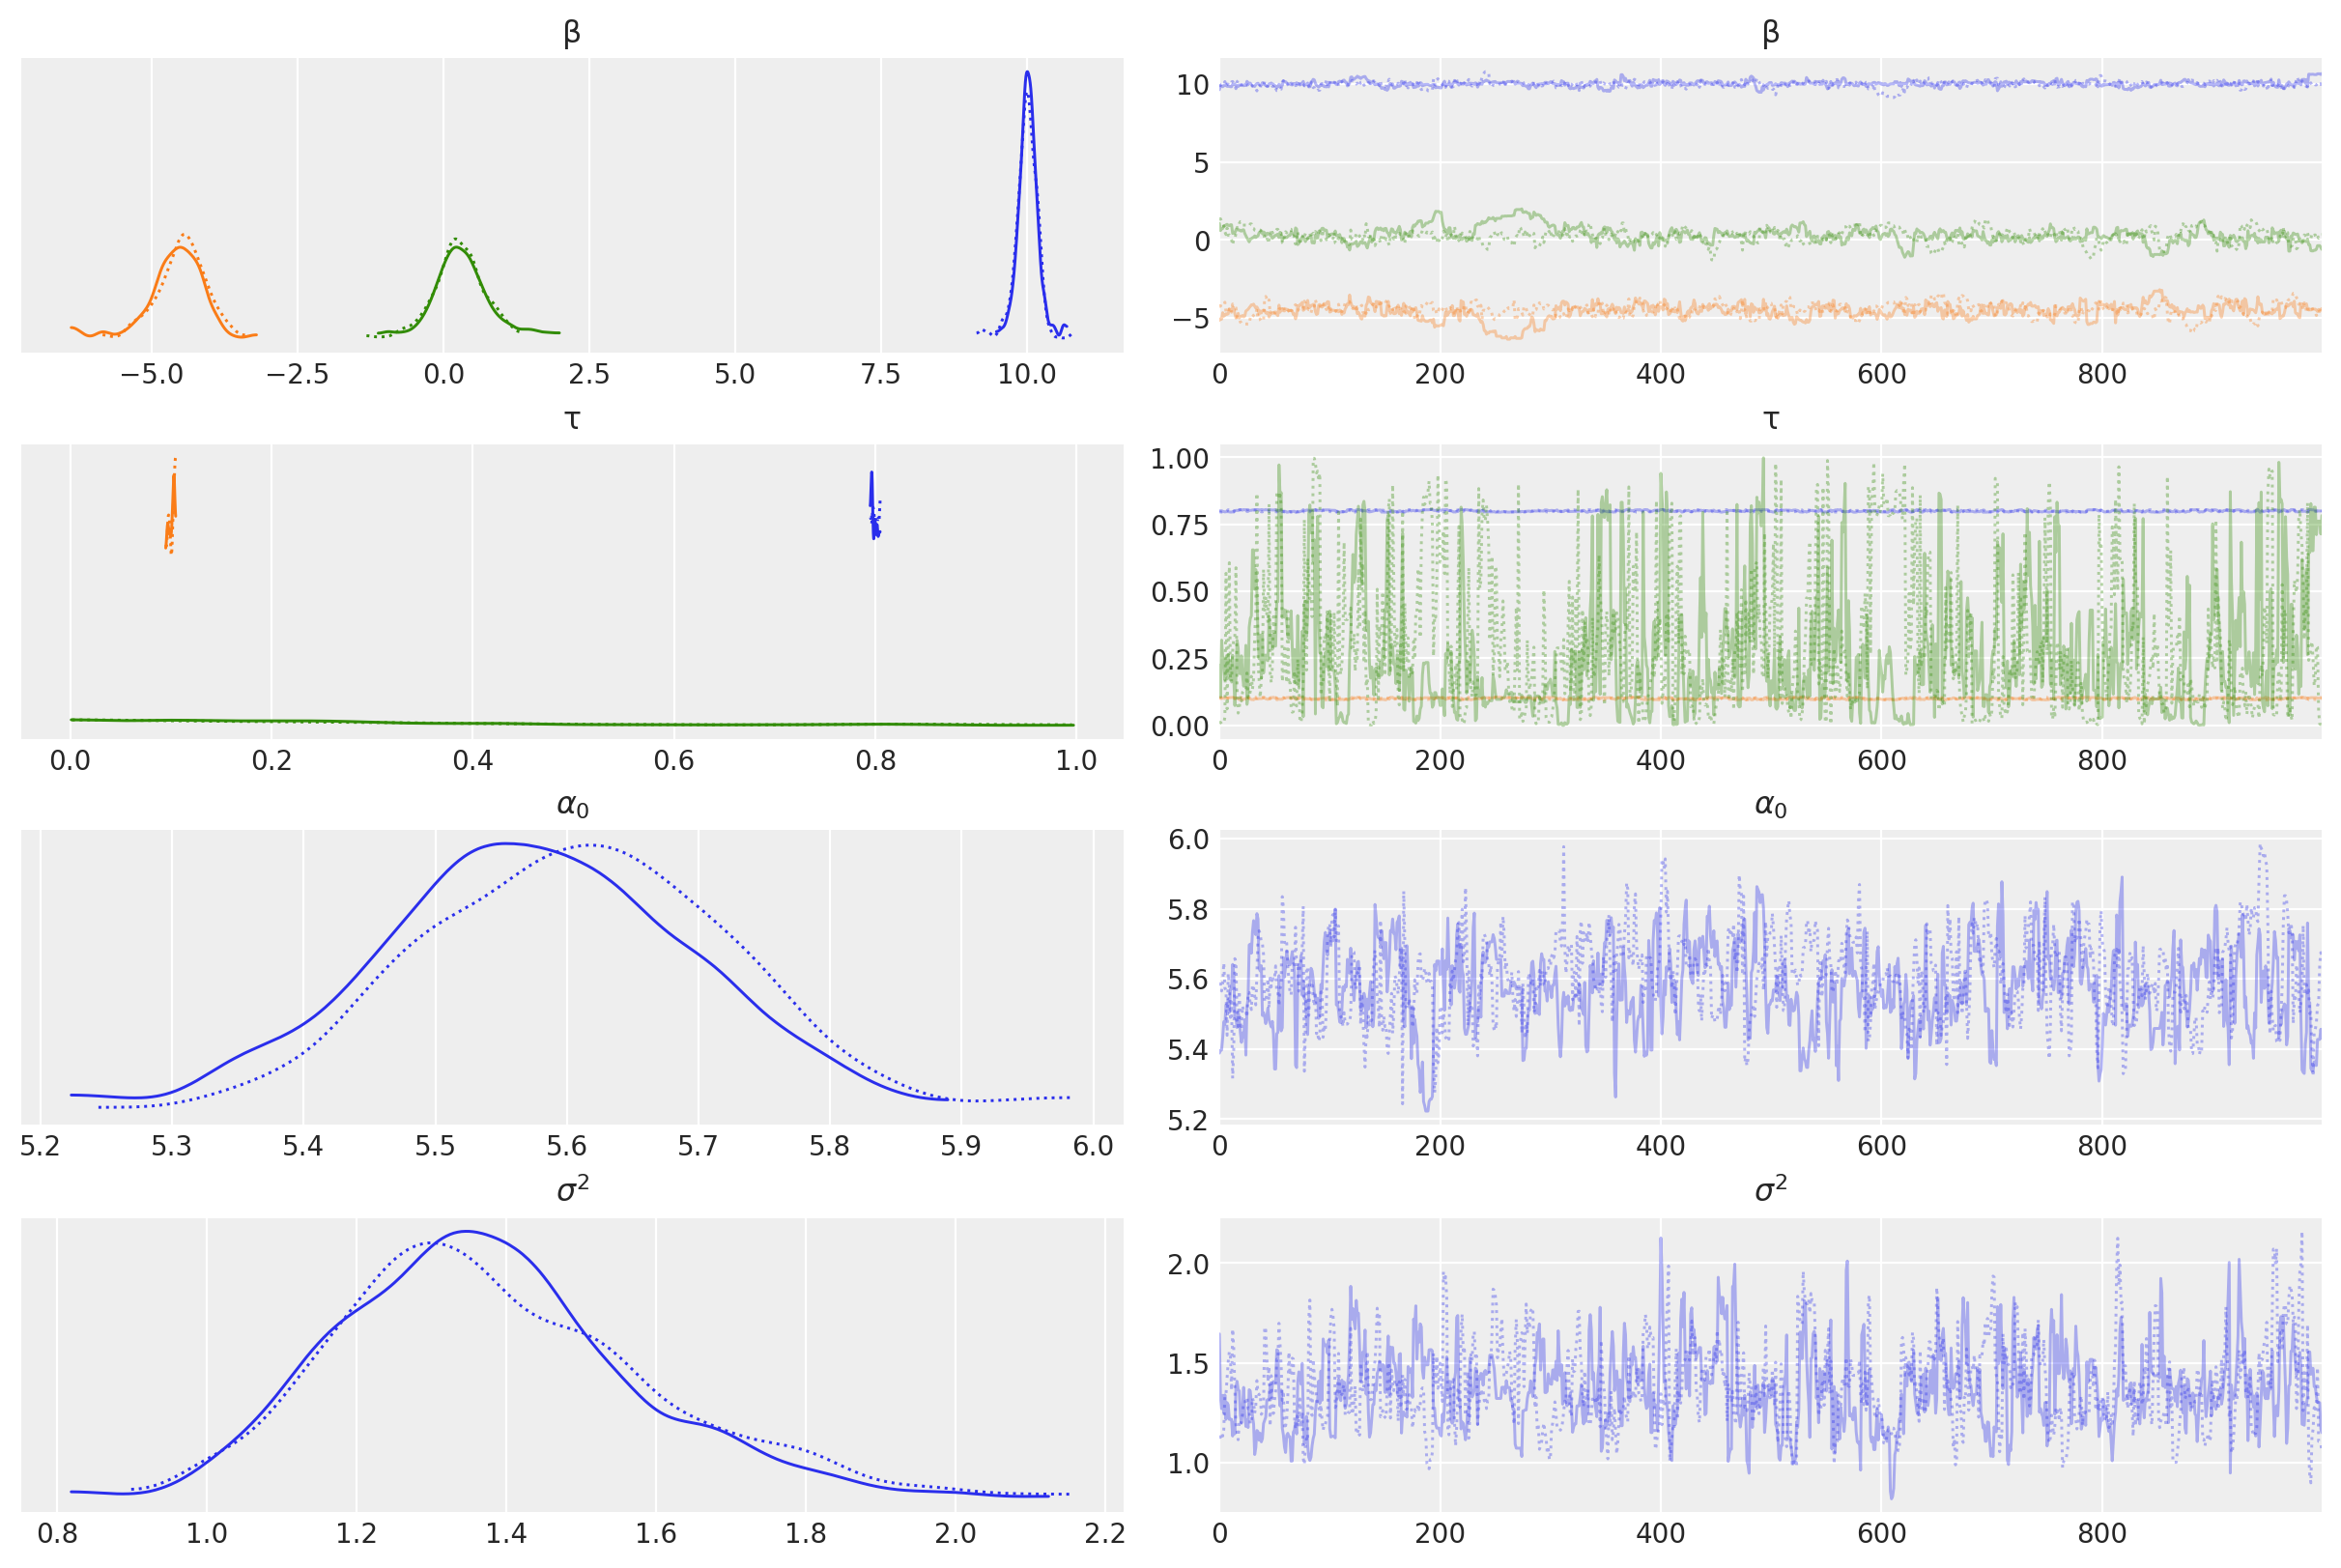

In [31]:
az.plot_trace(idata_pymc, var_names=theta_names, labeller=theta_labeller)
print("Density and trace plot:")

Marginal posterior distributions:


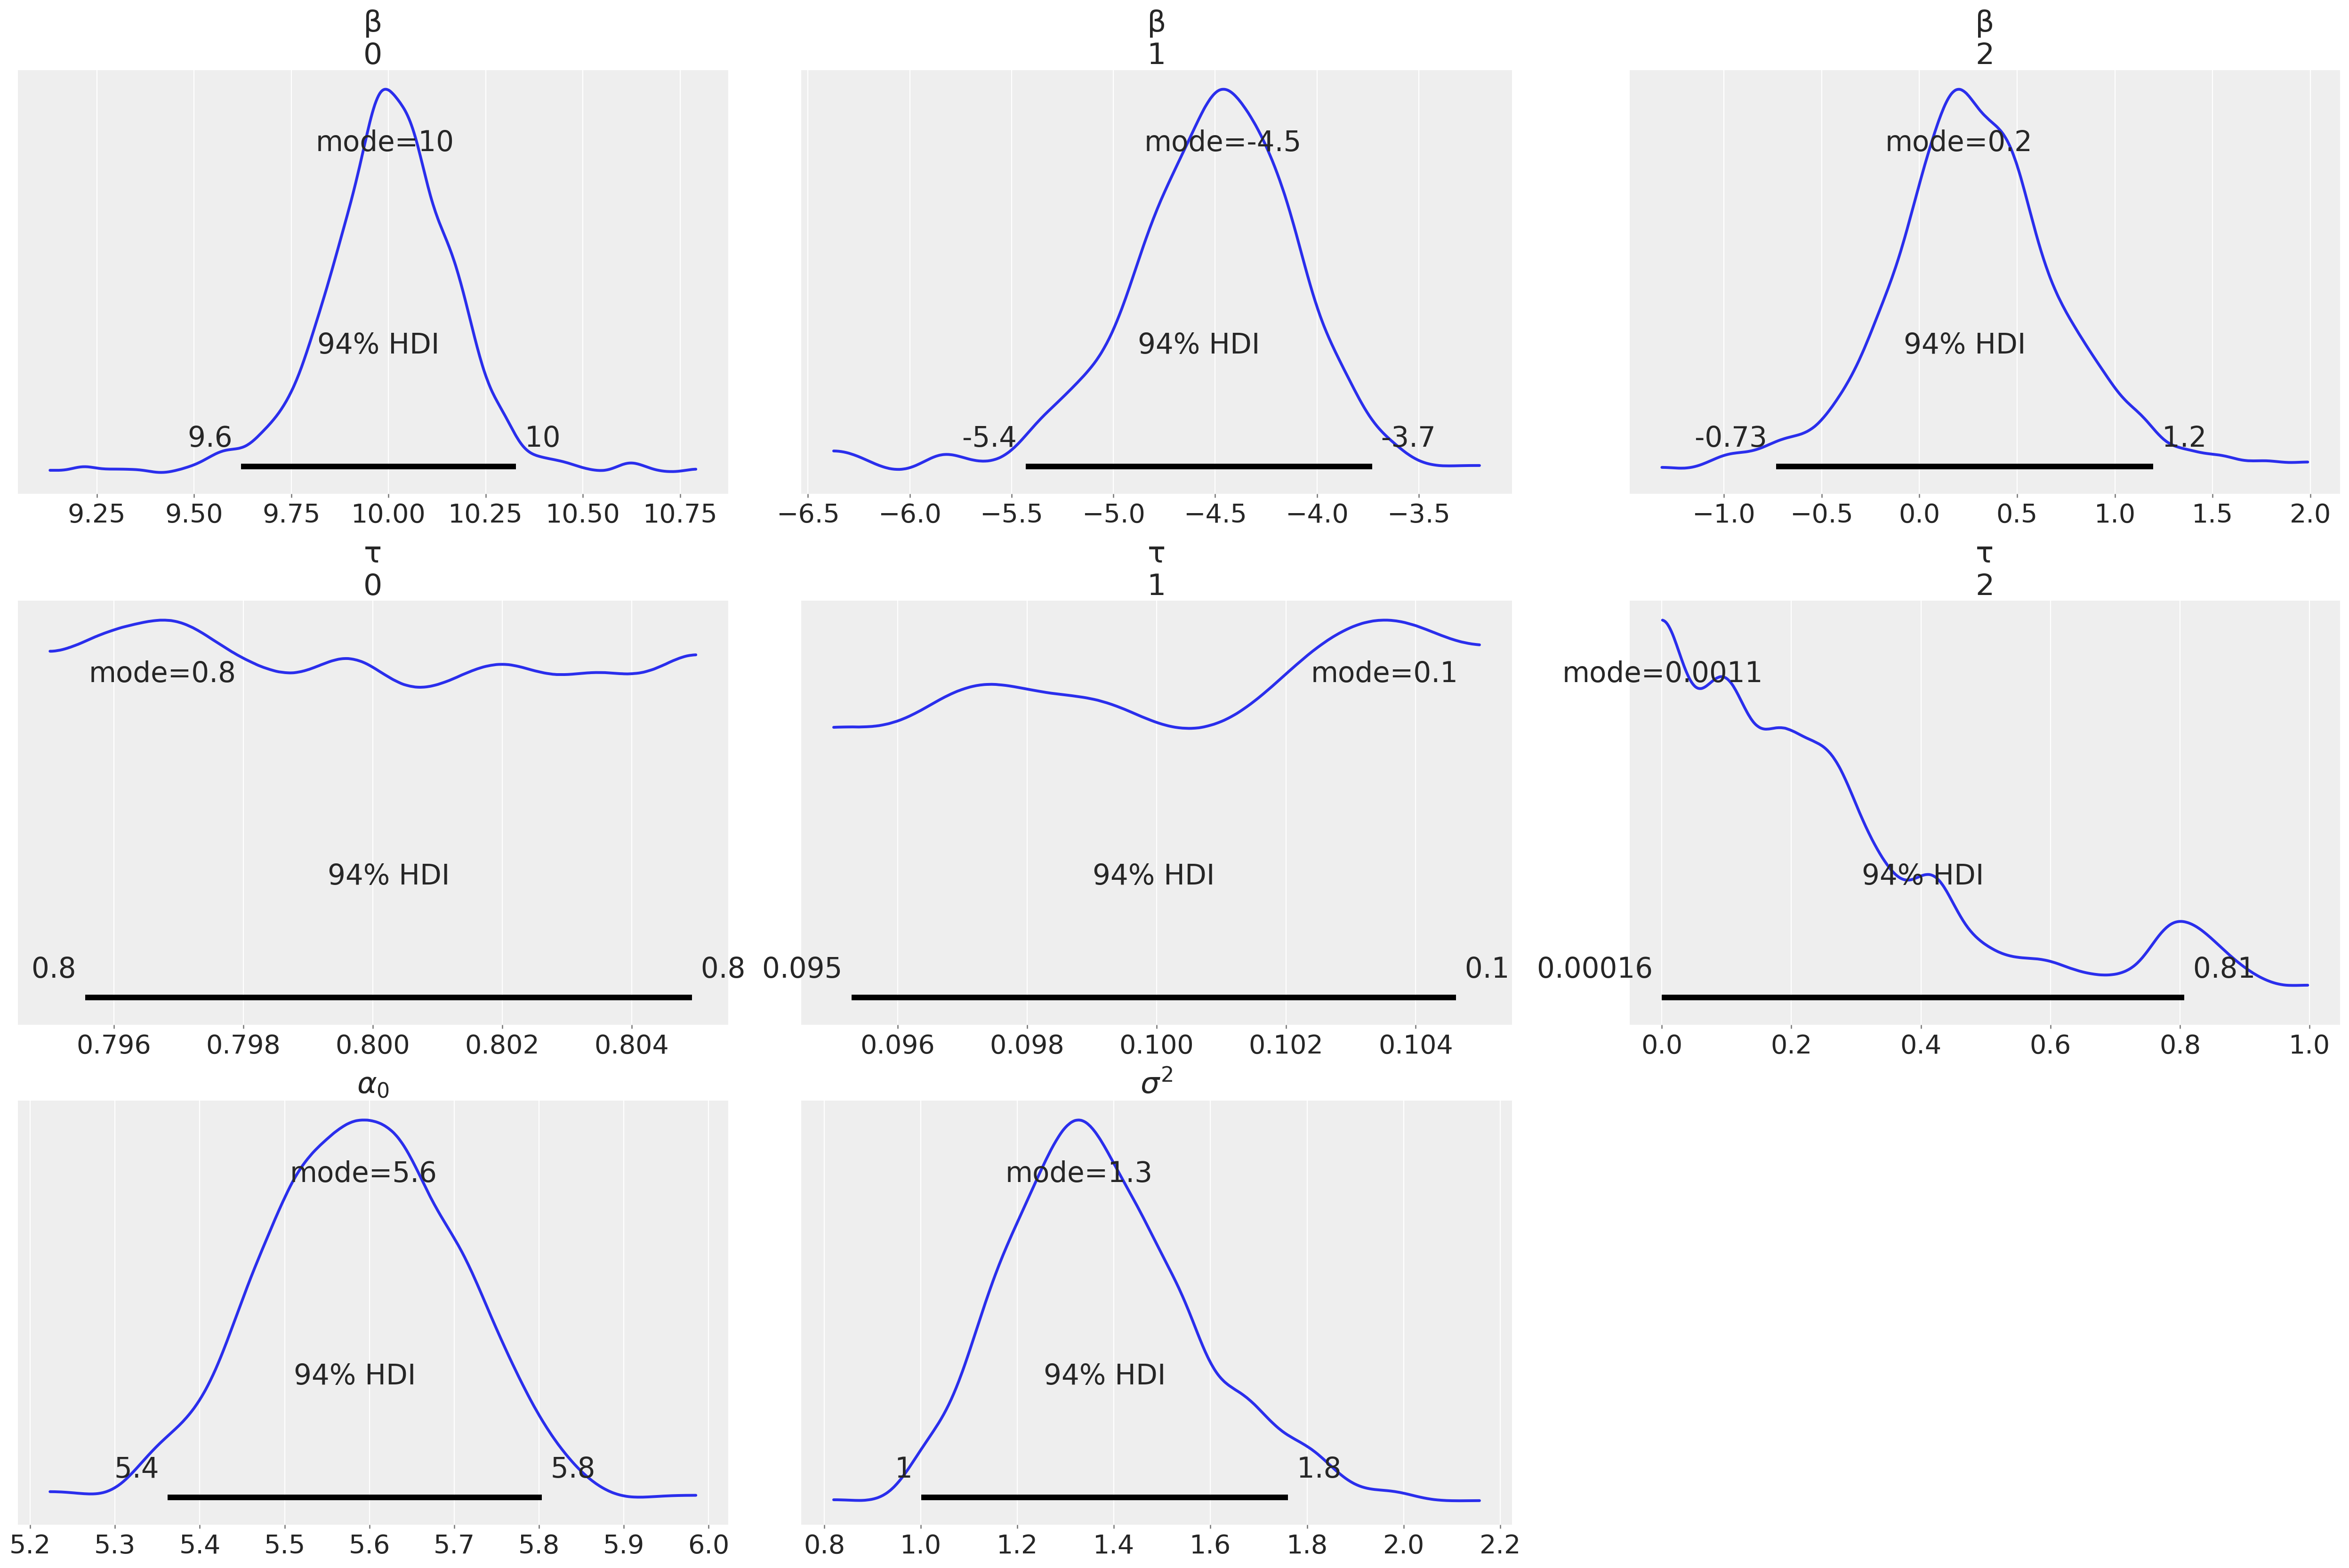

In [32]:
az.plot_posterior(
    idata_pymc, point_estimate='mode',
    var_names=theta_names,
    labeller=theta_labeller,
    textsize=20,
    grid=(NROWS(theta_ndim), NCOLS))
print("Marginal posterior distributions:")

Generating posterior predictive samples...


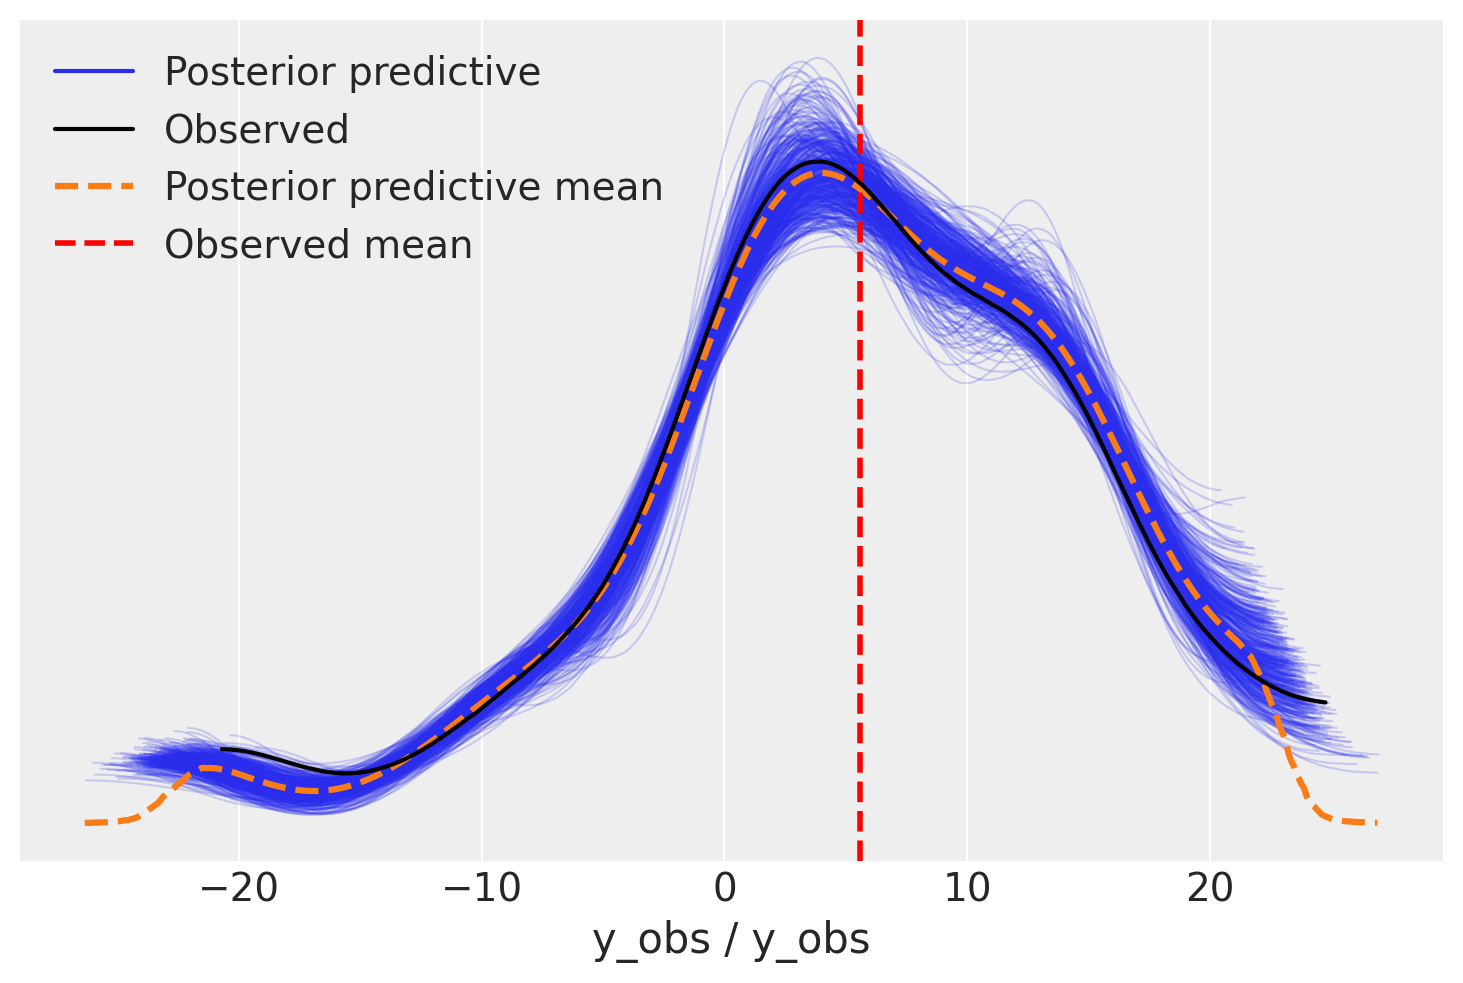

In [33]:
# -- Generate and plot posterior predictive samples from X

with model:
    print("Generating posterior predictive samples...")
    ppc = pm.sample_posterior_predictive(idata_pymc)
    idata_pymc.extend(az.from_pymc3(posterior_predictive=ppc))

utils.plot_ppc(idata_pymc, n_samples=500, data_pairs={'y_obs': 'y_obs'})

Combined autocorrelation times:


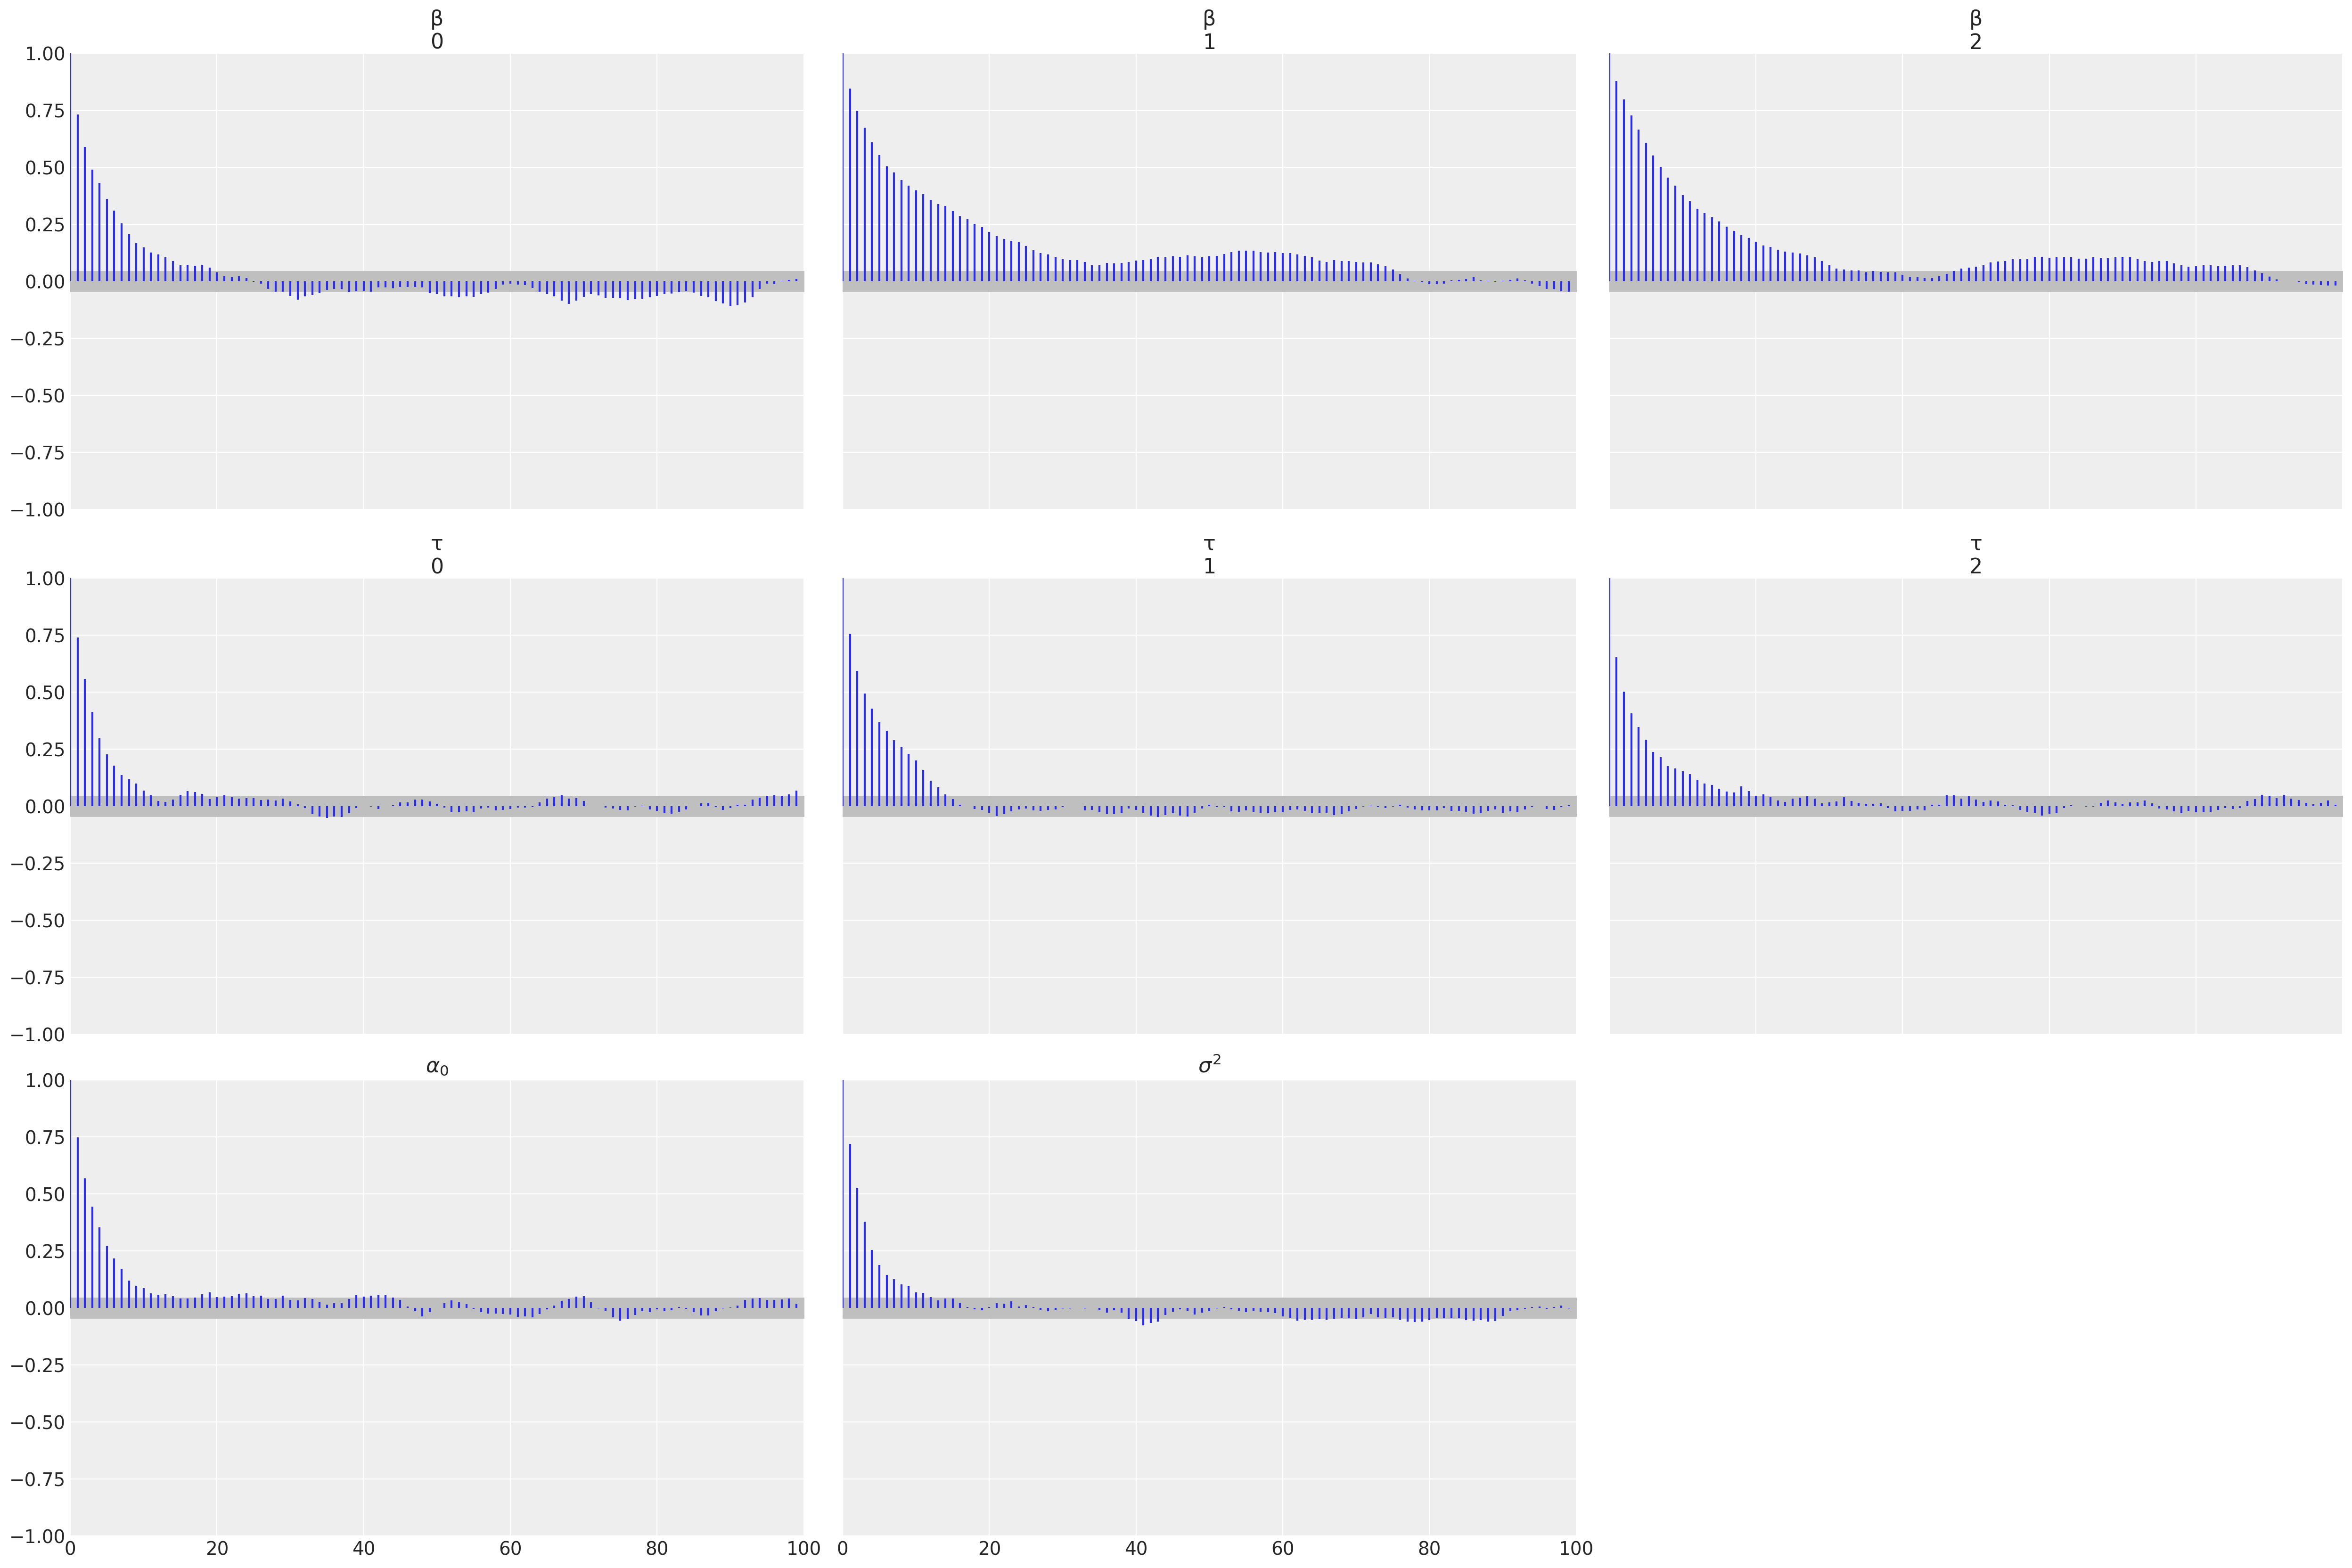

In [34]:
az.plot_autocorr(idata_pymc, var_names=theta_names,
                 combined=True, grid=(NROWS(theta_ndim), NCOLS),
                 labeller=theta_labeller)
print("Combined autocorrelation times:")

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

Generating posterior predictive on hold-out data...


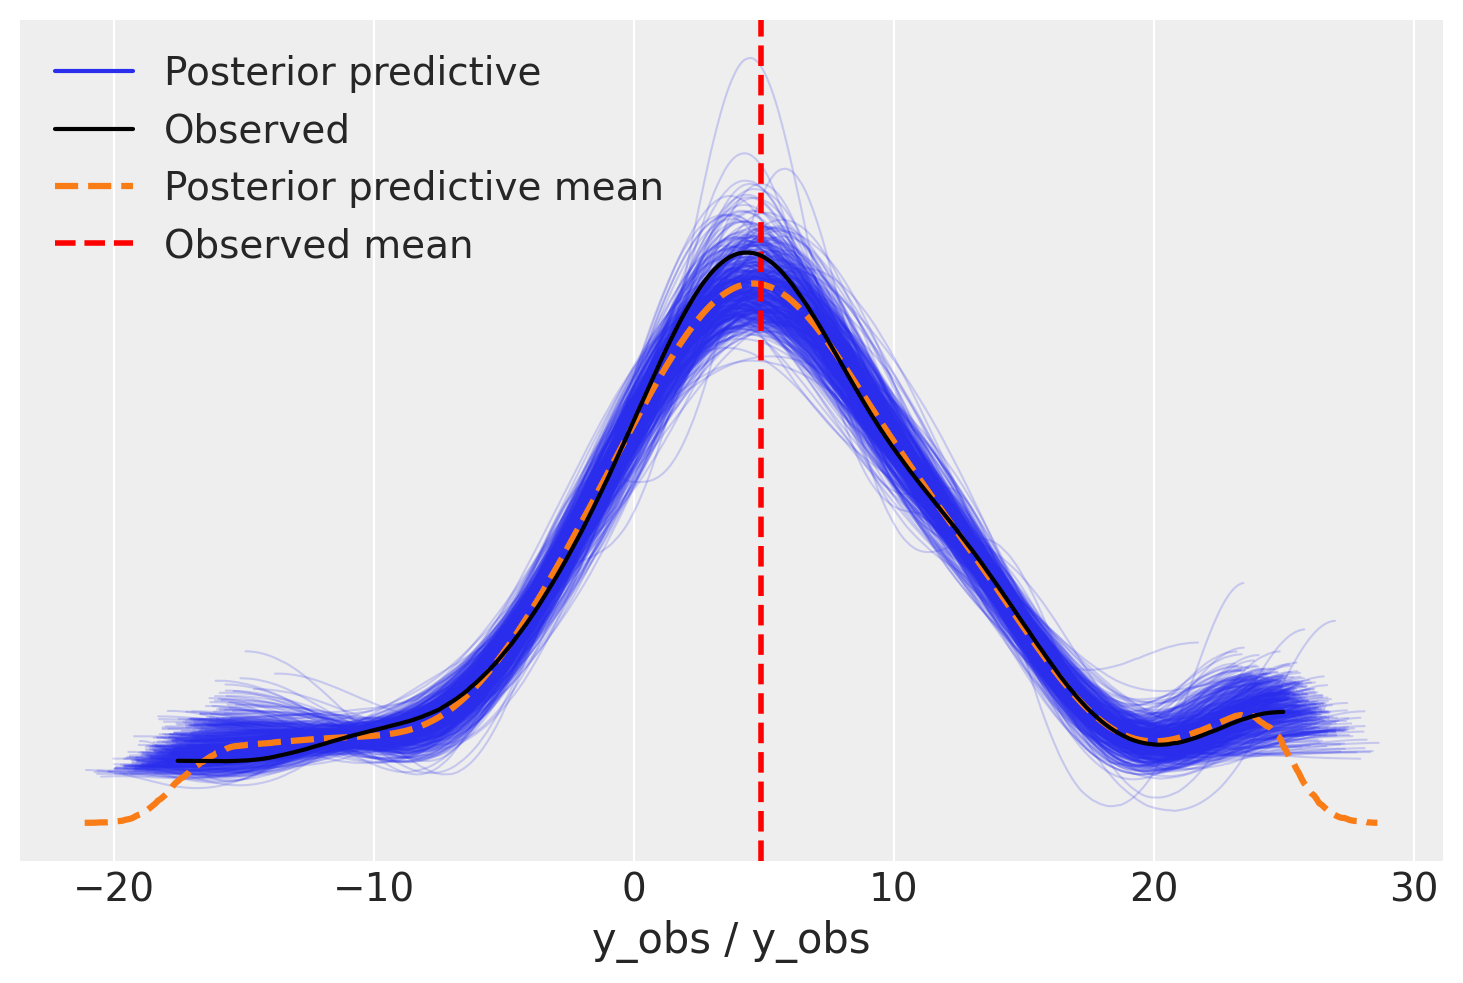

In [35]:
# -- Generate and plot posterior predictive samples from X_test

model_test = make_model(p_hat, g, eta, X_test, Y_test, theta_names,
                        theta_names_aux[:1], mle_theta)

with model_test:
    print("Generating posterior predictive on hold-out data...")
    ppc_test = pm.sample_posterior_predictive(idata_pymc)

utils.plot_ppc(
    az.from_pymc3(posterior_predictive=ppc_test, model=model_test),
    n_samples=500,
    data_pairs={'y_obs': 'y_obs'})

Next we look at the MSE when using several point-estimates for the parameters.

In [38]:
# -- Compute metrics using several point estimates

point_estimates = ["mode", "mean", "median"]

metrics_pymc = pd.DataFrame(columns=["Point estimate", "MSE", "RMSE", r"$R^2$"])

for pe in point_estimates:
    Y_hat = utils.point_predict(
        X_test, idata_pymc,
        theta_names, pe)
    metrics = utils.regression_metrics(Y_test, Y_hat)
    metrics_pymc.loc[pe] = [
        pe, 
        metrics["mse"], 
        np.sqrt(metrics["mse"]), 
        metrics["r2"]
    ]

metrics_pymc.style.hide_index()

### Save & Load

In [39]:
_ = idata_pymc.to_netcdf("pymc-p-fixed.nc")

In [34]:
idata_pymc = az.from_netcdf("pymc-p-fixed.nc")

## Notebook metadata

In [37]:
%load_ext watermark
%watermark - n - u - v - iv - w

Last updated: Tue Nov 02 2021

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

emcee     : 3.1.1
pymc3     : 3.11.4
json      : 2.0.9
scipy     : 1.7.1
theano    : 1.1.2
numpy     : 1.21.2
matplotlib: 3.4.3
arviz     : 0.11.4
autopep8  : 1.5.7
pandas    : 1.3.3

Watermark: 2.2.0

